# Introducing Neural Networks using TensorFlow and Keras Layers

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
print(pd.__version__)

0.23.3


In [5]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.9.0


In [6]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [7]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ai/master/notebooks/manning/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26822  100 26822    0     0  77970      0 --:--:-- --:--:-- --:--:-- 77970


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [10]:
df.head()

,max speed,age,thousand miles per year,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [11]:
# we deliberately decide this is going to be our label, it is often called lower case y
y=df['group']

In [12]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [13]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save same data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [17]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [18]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [19]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

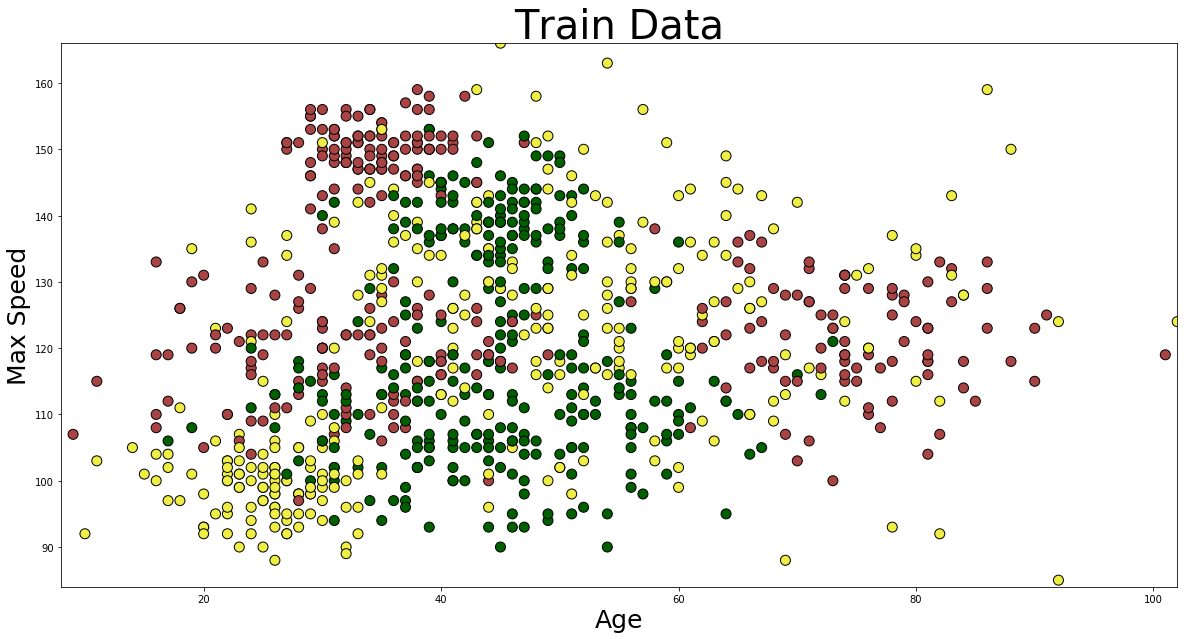

In [20]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

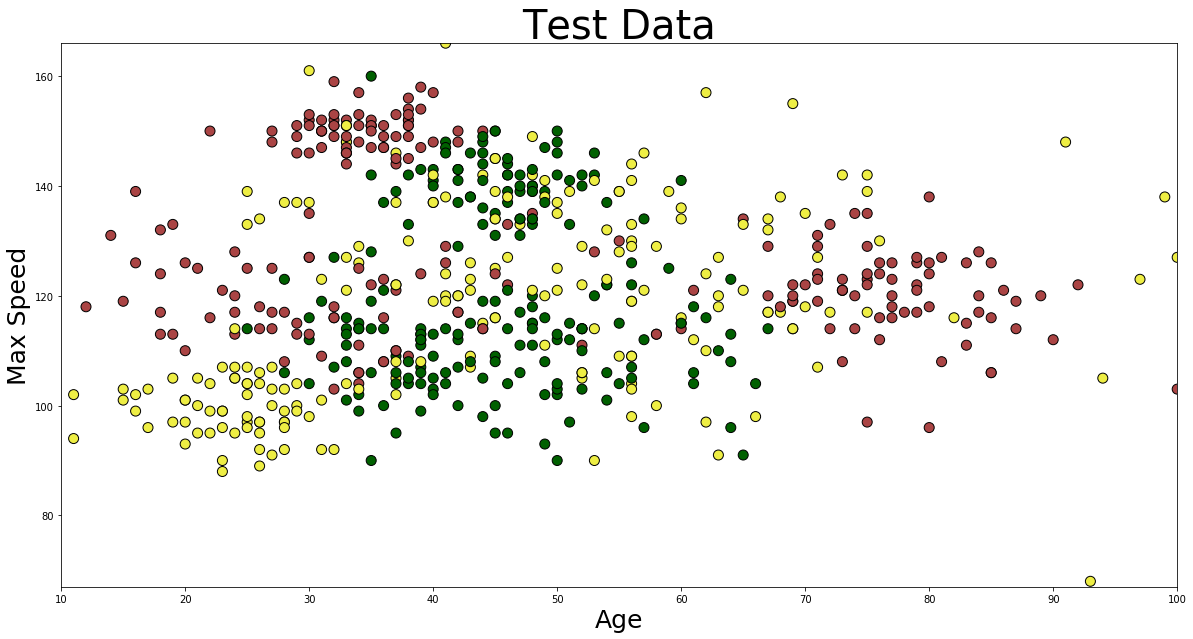

In [21]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

## Neural Networks using TensorFlow and Keras Layers
* Neural Networks consist of artificial neurons you organize in layers
* each neuron is very simple, but, theoretically, having enough of them in a single layer can approximate any funtion
* practically, we use 2 or 3 layers, as this has turned out to work well
* the more neurons and the more layers you use the longer the network takes to train
* neural networks often are no longer approachable using cross validation and grid search to find suitable hyper parameters

## Neuron (aka node or unit)

A neuron takes a number of numerical inputs, multiplies each with a weight, sums up all weighted input and adds bias (constant) to that sum. From this it creates a single numerical output. For one input (one dimension) this would be a description of a line. For more dimensions this describes a hyper plane that can serve as a decision boundary. Typically, this output is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

It is not really important to understand the details of a neural network. Practically how you configure them to form something more powerful is much more important. This, however, is still a very experimental domain, so there really is no conscise explanation and understanding how they work.


### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [22]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [23]:
model = tf.keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity

In [24]:
model.add(tf.keras.layers.Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(tf.keras.layers.Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [25]:
model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [28]:
# only if you are running this locally
!rm -rf ./tf_log
# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [30]:
BATCH_SIZE=1000
EPOCHS = 15000

# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
%time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/10000
720/720 [==============================] - 0s 19us/step - loss: 0.3980 - acc: 0.8208 - val_loss: 1.0122 - val_acc: 0.6778
Epoch 2/10000
720/720 [==============================] - 0s 10us/step - loss: 0.3982 - acc: 0.8278 - val_loss: 1.0306 - val_acc: 0.6722
Epoch 3/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3988 - acc: 0.8236 - val_loss: 1.0107 - val_acc: 0.6833
Epoch 4/10000
720/720 [==============================] - 0s 10us/step - loss: 0.3997 - acc: 0.8194 - val_loss: 1.0352 - val_acc: 0.6611
Epoch 5/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4010 - acc: 0.8250 - val_loss: 1.0099 - val_acc: 0.6778
Epoch 6/10000
720/720 [==============================] - 0s 10us/step - loss: 0.4028 - acc: 0.8167 - val_loss: 1.0414 - val_acc: 0.6611
Epoch 7/10000
720/720 [==============================] - 0s 10us/step - loss: 0.4049 - acc: 0.8250 - val_loss: 1.0083 - val_acc: 0.6833
Ep

Epoch 61/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3932 - acc: 0.8319 - val_loss: 1.0261 - val_acc: 0.6944
Epoch 62/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3942 - acc: 0.8250 - val_loss: 1.0367 - val_acc: 0.6611
Epoch 63/10000
720/720 [==============================] - 0s 27us/step - loss: 0.3956 - acc: 0.8347 - val_loss: 1.0217 - val_acc: 0.6889
Epoch 64/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3974 - acc: 0.8236 - val_loss: 1.0460 - val_acc: 0.6667
Epoch 65/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3991 - acc: 0.8278 - val_loss: 1.0159 - val_acc: 0.6833
Epoch 66/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4010 - acc: 0.8167 - val_loss: 1.0536 - val_acc: 0.6444
Epoch 67/10000
720/720 [==============================] - 0s 14us/step - loss: 0.4033 - acc: 0.8236 - val_loss: 1.0122 - val_acc: 0.6722
Epoch 68/10000
720/720 [==================

Epoch 121/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3939 - acc: 0.8194 - val_loss: 1.0206 - val_acc: 0.6778
Epoch 122/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3960 - acc: 0.8264 - val_loss: 1.0599 - val_acc: 0.6556
Epoch 123/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3981 - acc: 0.8264 - val_loss: 1.0216 - val_acc: 0.6722
Epoch 124/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3994 - acc: 0.8139 - val_loss: 1.0625 - val_acc: 0.6444
Epoch 125/10000
720/720 [==============================] - 0s 13us/step - loss: 0.4002 - acc: 0.8236 - val_loss: 1.0249 - val_acc: 0.6833
Epoch 126/10000
720/720 [==============================] - 0s 15us/step - loss: 0.3998 - acc: 0.8208 - val_loss: 1.0602 - val_acc: 0.6556
Epoch 127/10000
720/720 [==============================] - 0s 19us/step - loss: 0.3990 - acc: 0.8222 - val_loss: 1.0285 - val_acc: 0.6833
Epoch 128/10000
720/720 [=========

Epoch 181/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3916 - acc: 0.8222 - val_loss: 1.0307 - val_acc: 0.6722
Epoch 182/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3941 - acc: 0.8222 - val_loss: 1.0731 - val_acc: 0.6500
Epoch 183/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3974 - acc: 0.8222 - val_loss: 1.0287 - val_acc: 0.6722
Epoch 184/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3995 - acc: 0.8139 - val_loss: 1.0795 - val_acc: 0.6500
Epoch 185/10000
720/720 [==============================] - 0s 12us/step - loss: 0.4012 - acc: 0.8208 - val_loss: 1.0301 - val_acc: 0.6778
Epoch 186/10000
720/720 [==============================] - 0s 13us/step - loss: 0.4007 - acc: 0.8153 - val_loss: 1.0756 - val_acc: 0.6444
Epoch 187/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3988 - acc: 0.8236 - val_loss: 1.0350 - val_acc: 0.6833
Epoch 188/10000
720/720 [=========

Epoch 241/10000
720/720 [==============================] - 0s 7us/step - loss: 0.3925 - acc: 0.8222 - val_loss: 1.0392 - val_acc: 0.6778
Epoch 242/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3945 - acc: 0.8194 - val_loss: 1.0859 - val_acc: 0.6500
Epoch 243/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3968 - acc: 0.8208 - val_loss: 1.0381 - val_acc: 0.6778
Epoch 244/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3971 - acc: 0.8167 - val_loss: 1.0869 - val_acc: 0.6500
Epoch 245/10000
720/720 [==============================] - 0s 15us/step - loss: 0.3970 - acc: 0.8236 - val_loss: 1.0352 - val_acc: 0.6722
Epoch 246/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3939 - acc: 0.8208 - val_loss: 1.0784 - val_acc: 0.6556
Epoch 247/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3891 - acc: 0.8278 - val_loss: 1.0437 - val_acc: 0.6667
Epoch 248/10000
720/720 [===========

Epoch 301/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3900 - acc: 0.8236 - val_loss: 1.0444 - val_acc: 0.6667
Epoch 302/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3901 - acc: 0.8222 - val_loss: 1.0880 - val_acc: 0.6444
Epoch 303/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3882 - acc: 0.8264 - val_loss: 1.0519 - val_acc: 0.6778
Epoch 304/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3846 - acc: 0.8306 - val_loss: 1.0774 - val_acc: 0.6556
Epoch 305/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3812 - acc: 0.8361 - val_loss: 1.0605 - val_acc: 0.6778
Epoch 306/10000
720/720 [==============================] - 0s 28us/step - loss: 0.3792 - acc: 0.8292 - val_loss: 1.0661 - val_acc: 0.6611
Epoch 307/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3785 - acc: 0.8361 - val_loss: 1.0713 - val_acc: 0.6667
Epoch 308/10000
720/720 [=========

Epoch 361/10000
720/720 [==============================] - 0s 25us/step - loss: 0.3735 - acc: 0.8347 - val_loss: 1.0870 - val_acc: 0.6611
Epoch 362/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3768 - acc: 0.8347 - val_loss: 1.0542 - val_acc: 0.6778
Epoch 363/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3830 - acc: 0.8319 - val_loss: 1.0947 - val_acc: 0.6500
Epoch 364/10000
720/720 [==============================] - 0s 9us/step - loss: 0.3868 - acc: 0.8292 - val_loss: 1.0536 - val_acc: 0.6778
Epoch 365/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3873 - acc: 0.8264 - val_loss: 1.0974 - val_acc: 0.6500
Epoch 366/10000
720/720 [==============================] - 0s 29us/step - loss: 0.3850 - acc: 0.8278 - val_loss: 1.0629 - val_acc: 0.6778
Epoch 367/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3800 - acc: 0.8278 - val_loss: 1.0831 - val_acc: 0.6611
Epoch 368/10000
720/720 [===========

Epoch 421/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3844 - acc: 0.8278 - val_loss: 1.1158 - val_acc: 0.6444
Epoch 422/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3870 - acc: 0.8250 - val_loss: 1.0644 - val_acc: 0.6778
Epoch 423/10000
720/720 [==============================] - 0s 25us/step - loss: 0.3870 - acc: 0.8222 - val_loss: 1.1146 - val_acc: 0.6444
Epoch 424/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3858 - acc: 0.8292 - val_loss: 1.0663 - val_acc: 0.6833
Epoch 425/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3816 - acc: 0.8264 - val_loss: 1.1003 - val_acc: 0.6500
Epoch 426/10000
720/720 [==============================] - 0s 5us/step - loss: 0.3763 - acc: 0.8306 - val_loss: 1.0759 - val_acc: 0.6722
Epoch 427/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3720 - acc: 0.8292 - val_loss: 1.0836 - val_acc: 0.6611
Epoch 428/10000
720/720 [==========

Epoch 481/10000
720/720 [==============================] - 0s 26us/step - loss: 0.3816 - acc: 0.8333 - val_loss: 1.1219 - val_acc: 0.6389
Epoch 482/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3814 - acc: 0.8264 - val_loss: 1.0749 - val_acc: 0.6778
Epoch 483/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3788 - acc: 0.8292 - val_loss: 1.1140 - val_acc: 0.6444
Epoch 484/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3747 - acc: 0.8319 - val_loss: 1.0807 - val_acc: 0.6667
Epoch 485/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3702 - acc: 0.8250 - val_loss: 1.0995 - val_acc: 0.6611
Epoch 486/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3663 - acc: 0.8375 - val_loss: 1.0898 - val_acc: 0.6667
Epoch 487/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3650 - acc: 0.8347 - val_loss: 1.0871 - val_acc: 0.6722
Epoch 488/10000
720/720 [=========

Epoch 541/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3732 - acc: 0.8347 - val_loss: 1.1208 - val_acc: 0.6500
Epoch 542/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3710 - acc: 0.8333 - val_loss: 1.0924 - val_acc: 0.6722
Epoch 543/10000
720/720 [==============================] - 0s 21us/step - loss: 0.3677 - acc: 0.8347 - val_loss: 1.1092 - val_acc: 0.6556
Epoch 544/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3644 - acc: 0.8417 - val_loss: 1.0981 - val_acc: 0.6778
Epoch 545/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3620 - acc: 0.8361 - val_loss: 1.1021 - val_acc: 0.6667
Epoch 546/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3608 - acc: 0.8361 - val_loss: 1.1038 - val_acc: 0.6556
Epoch 547/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3612 - acc: 0.8375 - val_loss: 1.0963 - val_acc: 0.6722
Epoch 548/10000
720/720 [==========

Epoch 601/10000
720/720 [==============================] - 0s 1us/step - loss: 0.3663 - acc: 0.8375 - val_loss: 1.1349 - val_acc: 0.6444
Epoch 602/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3682 - acc: 0.8306 - val_loss: 1.0975 - val_acc: 0.6722
Epoch 603/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3694 - acc: 0.8292 - val_loss: 1.1375 - val_acc: 0.6333
Epoch 604/10000
720/720 [==============================] - 0s 27us/step - loss: 0.3705 - acc: 0.8347 - val_loss: 1.0979 - val_acc: 0.6833
Epoch 605/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3702 - acc: 0.8306 - val_loss: 1.1318 - val_acc: 0.6500
Epoch 606/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3680 - acc: 0.8347 - val_loss: 1.1010 - val_acc: 0.6667
Epoch 607/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3646 - acc: 0.8347 - val_loss: 1.1209 - val_acc: 0.6556
Epoch 608/10000
720/720 [===========

Epoch 661/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3687 - acc: 0.8417 - val_loss: 1.1526 - val_acc: 0.6333
Epoch 662/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3725 - acc: 0.8306 - val_loss: 1.1005 - val_acc: 0.6722
Epoch 663/10000
720/720 [==============================] - 0s 21us/step - loss: 0.3736 - acc: 0.8319 - val_loss: 1.1543 - val_acc: 0.6444
Epoch 664/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3743 - acc: 0.8306 - val_loss: 1.1016 - val_acc: 0.6778
Epoch 665/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3714 - acc: 0.8306 - val_loss: 1.1430 - val_acc: 0.6389
Epoch 666/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3660 - acc: 0.8319 - val_loss: 1.1055 - val_acc: 0.6722
Epoch 667/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3600 - acc: 0.8333 - val_loss: 1.1261 - val_acc: 0.6556
Epoch 668/10000
720/720 [==========

Epoch 721/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3612 - acc: 0.8389 - val_loss: 1.1571 - val_acc: 0.6444
Epoch 722/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3643 - acc: 0.8347 - val_loss: 1.1121 - val_acc: 0.6889
Epoch 723/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3669 - acc: 0.8333 - val_loss: 1.1640 - val_acc: 0.6333
Epoch 724/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3699 - acc: 0.8319 - val_loss: 1.1115 - val_acc: 0.6722
Epoch 725/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3706 - acc: 0.8306 - val_loss: 1.1639 - val_acc: 0.6333
Epoch 726/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3700 - acc: 0.8319 - val_loss: 1.1097 - val_acc: 0.6667
Epoch 727/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3660 - acc: 0.8417 - val_loss: 1.1531 - val_acc: 0.6611
Epoch 728/10000
720/720 [=========

Epoch 781/10000
720/720 [==============================] - 0s 25us/step - loss: 0.3518 - acc: 0.8333 - val_loss: 1.1564 - val_acc: 0.6556
Epoch 782/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3533 - acc: 0.8389 - val_loss: 1.1276 - val_acc: 0.6833
Epoch 783/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3553 - acc: 0.8375 - val_loss: 1.1652 - val_acc: 0.6389
Epoch 784/10000
720/720 [==============================] - 0s 8us/step - loss: 0.3582 - acc: 0.8319 - val_loss: 1.1238 - val_acc: 0.6778
Epoch 785/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3610 - acc: 0.8375 - val_loss: 1.1732 - val_acc: 0.6389
Epoch 786/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3652 - acc: 0.8319 - val_loss: 1.1220 - val_acc: 0.6667
Epoch 787/10000
720/720 [==============================] - 0s 20us/step - loss: 0.3667 - acc: 0.8361 - val_loss: 1.1759 - val_acc: 0.6333
Epoch 788/10000
720/720 [===========

Epoch 841/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3477 - acc: 0.8458 - val_loss: 1.1589 - val_acc: 0.6556
Epoch 842/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3480 - acc: 0.8431 - val_loss: 1.1385 - val_acc: 0.6667
Epoch 843/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3481 - acc: 0.8458 - val_loss: 1.1656 - val_acc: 0.6500
Epoch 844/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3493 - acc: 0.8389 - val_loss: 1.1320 - val_acc: 0.6667
Epoch 845/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3517 - acc: 0.8361 - val_loss: 1.1735 - val_acc: 0.6444
Epoch 846/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3553 - acc: 0.8389 - val_loss: 1.1328 - val_acc: 0.6500
Epoch 847/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3596 - acc: 0.8347 - val_loss: 1.1852 - val_acc: 0.6444
Epoch 848/10000
720/720 [=========

Epoch 901/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3526 - acc: 0.8403 - val_loss: 1.1825 - val_acc: 0.6389
Epoch 902/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3507 - acc: 0.8389 - val_loss: 1.1437 - val_acc: 0.6556
Epoch 903/10000
720/720 [==============================] - 0s 18us/step - loss: 0.3475 - acc: 0.8431 - val_loss: 1.1732 - val_acc: 0.6500
Epoch 904/10000
720/720 [==============================] - 0s 17us/step - loss: 0.3442 - acc: 0.8389 - val_loss: 1.1495 - val_acc: 0.6611
Epoch 905/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3411 - acc: 0.8444 - val_loss: 1.1624 - val_acc: 0.6556
Epoch 906/10000
720/720 [==============================] - 0s 21us/step - loss: 0.3392 - acc: 0.8417 - val_loss: 1.1599 - val_acc: 0.6556
Epoch 907/10000
720/720 [==============================] - 0s 25us/step - loss: 0.3386 - acc: 0.8403 - val_loss: 1.1555 - val_acc: 0.6556
Epoch 908/10000
720/720 [=========

Epoch 961/10000
720/720 [==============================] - 0s 25us/step - loss: 0.3477 - acc: 0.8403 - val_loss: 1.1980 - val_acc: 0.6389
Epoch 962/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3492 - acc: 0.8389 - val_loss: 1.1548 - val_acc: 0.6556
Epoch 963/10000
720/720 [==============================] - 0s 15us/step - loss: 0.3497 - acc: 0.8417 - val_loss: 1.1961 - val_acc: 0.6389
Epoch 964/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3492 - acc: 0.8403 - val_loss: 1.1556 - val_acc: 0.6722
Epoch 965/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3474 - acc: 0.8444 - val_loss: 1.1893 - val_acc: 0.6500
Epoch 966/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3456 - acc: 0.8389 - val_loss: 1.1568 - val_acc: 0.6778
Epoch 967/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3426 - acc: 0.8486 - val_loss: 1.1804 - val_acc: 0.6500
Epoch 968/10000
720/720 [===========

Epoch 1021/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3424 - acc: 0.8417 - val_loss: 1.2000 - val_acc: 0.6444
Epoch 1022/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3443 - acc: 0.8431 - val_loss: 1.1634 - val_acc: 0.6722
Epoch 1023/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3449 - acc: 0.8444 - val_loss: 1.2018 - val_acc: 0.6444
Epoch 1024/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3450 - acc: 0.8403 - val_loss: 1.1636 - val_acc: 0.6667
Epoch 1025/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3433 - acc: 0.8431 - val_loss: 1.2007 - val_acc: 0.6444
Epoch 1026/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3417 - acc: 0.8431 - val_loss: 1.1651 - val_acc: 0.6667
Epoch 1027/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3390 - acc: 0.8403 - val_loss: 1.1961 - val_acc: 0.6444
Epoch 1028/10000
720/720 [=

Epoch 1080/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3362 - acc: 0.8444 - val_loss: 1.1782 - val_acc: 0.6444
Epoch 1081/10000
720/720 [==============================] - 0s 15us/step - loss: 0.3367 - acc: 0.8403 - val_loss: 1.2085 - val_acc: 0.6611
Epoch 1082/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3381 - acc: 0.8431 - val_loss: 1.1742 - val_acc: 0.6611
Epoch 1083/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3395 - acc: 0.8403 - val_loss: 1.2110 - val_acc: 0.6500
Epoch 1084/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3392 - acc: 0.8431 - val_loss: 1.1761 - val_acc: 0.6611
Epoch 1085/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3385 - acc: 0.8444 - val_loss: 1.2124 - val_acc: 0.6389
Epoch 1086/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3390 - acc: 0.8472 - val_loss: 1.1742 - val_acc: 0.6611
Epoch 1087/10000
720/720 [=

Epoch 1139/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3324 - acc: 0.8486 - val_loss: 1.2062 - val_acc: 0.6611
Epoch 1140/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3340 - acc: 0.8486 - val_loss: 1.2144 - val_acc: 0.6444
Epoch 1141/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3308 - acc: 0.8444 - val_loss: 1.1902 - val_acc: 0.6500
Epoch 1142/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3326 - acc: 0.8417 - val_loss: 1.2227 - val_acc: 0.6389
Epoch 1143/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3281 - acc: 0.8458 - val_loss: 1.1933 - val_acc: 0.6722
Epoch 1144/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3298 - acc: 0.8486 - val_loss: 1.1903 - val_acc: 0.6611
Epoch 1145/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3291 - acc: 0.8444 - val_loss: 1.2023 - val_acc: 0.6500
Epoch 1146/10000
720/720 [=

Epoch 1198/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3277 - acc: 0.8486 - val_loss: 1.2013 - val_acc: 0.6722
Epoch 1199/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3263 - acc: 0.8500 - val_loss: 1.2133 - val_acc: 0.6500
Epoch 1200/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3249 - acc: 0.8472 - val_loss: 1.2059 - val_acc: 0.6556
Epoch 1201/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3232 - acc: 0.8431 - val_loss: 1.2093 - val_acc: 0.6389
Epoch 1202/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3219 - acc: 0.8417 - val_loss: 1.2089 - val_acc: 0.6556
Epoch 1203/10000
720/720 [==============================] - 0s 17us/step - loss: 0.3219 - acc: 0.8500 - val_loss: 1.2083 - val_acc: 0.6389
Epoch 1204/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3225 - acc: 0.8458 - val_loss: 1.2220 - val_acc: 0.6444
Epoch 1205/10000
720/720 [=

Epoch 1257/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3320 - acc: 0.8472 - val_loss: 1.2399 - val_acc: 0.6333
Epoch 1258/10000
720/720 [==============================] - 0s 24us/step - loss: 0.3289 - acc: 0.8444 - val_loss: 1.2052 - val_acc: 0.6389
Epoch 1259/10000
720/720 [==============================] - 0s 6us/step - loss: 0.3243 - acc: 0.8472 - val_loss: 1.2300 - val_acc: 0.6389
Epoch 1260/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3207 - acc: 0.8472 - val_loss: 1.2180 - val_acc: 0.6500
Epoch 1261/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3190 - acc: 0.8472 - val_loss: 1.2167 - val_acc: 0.6444
Epoch 1262/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3192 - acc: 0.8444 - val_loss: 1.2287 - val_acc: 0.6500
Epoch 1263/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3206 - acc: 0.8528 - val_loss: 1.2117 - val_acc: 0.6444
Epoch 1264/10000
720/720 [====

Epoch 1317/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3203 - acc: 0.8472 - val_loss: 1.2205 - val_acc: 0.6722
Epoch 1318/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3226 - acc: 0.8556 - val_loss: 1.2447 - val_acc: 0.6278
Epoch 1319/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3237 - acc: 0.8458 - val_loss: 1.2183 - val_acc: 0.6667
Epoch 1320/10000
720/720 [==============================] - 0s 21us/step - loss: 0.3236 - acc: 0.8500 - val_loss: 1.2383 - val_acc: 0.6389
Epoch 1321/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3209 - acc: 0.8417 - val_loss: 1.2203 - val_acc: 0.6556
Epoch 1322/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3171 - acc: 0.8486 - val_loss: 1.2313 - val_acc: 0.6389
Epoch 1323/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3154 - acc: 0.8528 - val_loss: 1.2298 - val_acc: 0.6444
Epoch 1324/10000
720/720 [=

Epoch 1376/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3129 - acc: 0.8514 - val_loss: 1.2460 - val_acc: 0.6500
Epoch 1377/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3135 - acc: 0.8542 - val_loss: 1.2286 - val_acc: 0.6500
Epoch 1378/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3169 - acc: 0.8472 - val_loss: 1.2618 - val_acc: 0.6500
Epoch 1379/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3208 - acc: 0.8486 - val_loss: 1.2243 - val_acc: 0.6500
Epoch 1380/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3229 - acc: 0.8486 - val_loss: 1.2616 - val_acc: 0.6389
Epoch 1381/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3231 - acc: 0.8472 - val_loss: 1.2255 - val_acc: 0.6500
Epoch 1382/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3207 - acc: 0.8486 - val_loss: 1.2535 - val_acc: 0.6389
Epoch 1383/10000
720/720 [=

Epoch 1435/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3454 - acc: 0.8458 - val_loss: 1.2208 - val_acc: 0.6611
Epoch 1436/10000
720/720 [==============================] - 0s 8us/step - loss: 0.3498 - acc: 0.8361 - val_loss: 1.3038 - val_acc: 0.6389
Epoch 1437/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3571 - acc: 0.8347 - val_loss: 1.2196 - val_acc: 0.6667
Epoch 1438/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3508 - acc: 0.8361 - val_loss: 1.2910 - val_acc: 0.6333
Epoch 1439/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3396 - acc: 0.8431 - val_loss: 1.2278 - val_acc: 0.6556
Epoch 1440/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3211 - acc: 0.8486 - val_loss: 1.2495 - val_acc: 0.6333
Epoch 1441/10000
720/720 [==============================] - 0s 27us/step - loss: 0.3112 - acc: 0.8556 - val_loss: 1.2714 - val_acc: 0.6556
Epoch 1442/10000
720/720 [====

Epoch 1495/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3314 - acc: 0.8444 - val_loss: 1.2345 - val_acc: 0.6667
Epoch 1496/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3292 - acc: 0.8528 - val_loss: 1.2922 - val_acc: 0.6111
Epoch 1497/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3264 - acc: 0.8458 - val_loss: 1.2391 - val_acc: 0.6611
Epoch 1498/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3191 - acc: 0.8556 - val_loss: 1.2709 - val_acc: 0.6278
Epoch 1499/10000
720/720 [==============================] - 0s 24us/step - loss: 0.3118 - acc: 0.8569 - val_loss: 1.2545 - val_acc: 0.6611
Epoch 1500/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3069 - acc: 0.8556 - val_loss: 1.2516 - val_acc: 0.6556
Epoch 1501/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3068 - acc: 0.8556 - val_loss: 1.2772 - val_acc: 0.6444
Epoch 1502/10000
720/720 [=

Epoch 1554/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3136 - acc: 0.8542 - val_loss: 1.2843 - val_acc: 0.6500
Epoch 1555/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3086 - acc: 0.8514 - val_loss: 1.2602 - val_acc: 0.6444
Epoch 1556/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3040 - acc: 0.8556 - val_loss: 1.2703 - val_acc: 0.6444
Epoch 1557/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3021 - acc: 0.8625 - val_loss: 1.2797 - val_acc: 0.6500
Epoch 1558/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3026 - acc: 0.8556 - val_loss: 1.2631 - val_acc: 0.6444
Epoch 1559/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3045 - acc: 0.8556 - val_loss: 1.2873 - val_acc: 0.6500
Epoch 1560/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3074 - acc: 0.8569 - val_loss: 1.2601 - val_acc: 0.6444
Epoch 1561/10000
720/720 [=

Epoch 1613/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3177 - acc: 0.8514 - val_loss: 1.2587 - val_acc: 0.6500
Epoch 1614/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3110 - acc: 0.8597 - val_loss: 1.2911 - val_acc: 0.6333
Epoch 1615/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3058 - acc: 0.8625 - val_loss: 1.2771 - val_acc: 0.6667
Epoch 1616/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3036 - acc: 0.8556 - val_loss: 1.2726 - val_acc: 0.6444
Epoch 1617/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3038 - acc: 0.8583 - val_loss: 1.2898 - val_acc: 0.6500
Epoch 1618/10000
720/720 [==============================] - 0s 26us/step - loss: 0.3056 - acc: 0.8597 - val_loss: 1.2663 - val_acc: 0.6444
Epoch 1619/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3078 - acc: 0.8569 - val_loss: 1.2979 - val_acc: 0.6500
Epoch 1620/10000
720/720 [=

Epoch 1673/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3051 - acc: 0.8556 - val_loss: 1.2797 - val_acc: 0.6556
Epoch 1674/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3280 - acc: 0.8431 - val_loss: 1.3493 - val_acc: 0.6167
Epoch 1675/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3376 - acc: 0.8431 - val_loss: 1.2668 - val_acc: 0.6611
Epoch 1676/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3211 - acc: 0.8514 - val_loss: 1.2924 - val_acc: 0.6556
Epoch 1677/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3029 - acc: 0.8514 - val_loss: 1.2959 - val_acc: 0.6444
Epoch 1678/10000
720/720 [==============================] - 0s 19us/step - loss: 0.3048 - acc: 0.8639 - val_loss: 1.2690 - val_acc: 0.6389
Epoch 1679/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3212 - acc: 0.8569 - val_loss: 1.3256 - val_acc: 0.6444
Epoch 1680/10000
720/720 [=

Epoch 1732/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2923 - acc: 0.8681 - val_loss: 1.3009 - val_acc: 0.6556
Epoch 1733/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2922 - acc: 0.8653 - val_loss: 1.2995 - val_acc: 0.6500
Epoch 1734/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2922 - acc: 0.8625 - val_loss: 1.2999 - val_acc: 0.6444
Epoch 1735/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2922 - acc: 0.8653 - val_loss: 1.2983 - val_acc: 0.6500
Epoch 1736/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2921 - acc: 0.8639 - val_loss: 1.3000 - val_acc: 0.6500
Epoch 1737/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2921 - acc: 0.8653 - val_loss: 1.2996 - val_acc: 0.6500
Epoch 1738/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2920 - acc: 0.8639 - val_loss: 1.3021 - val_acc: 0.6500
Epoch 1739/10000
720/720 [=

Epoch 1791/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3847 - acc: 0.8306 - val_loss: 1.3370 - val_acc: 0.6611
Epoch 1792/10000
720/720 [==============================] - 0s 22us/step - loss: 0.4009 - acc: 0.8125 - val_loss: 1.2775 - val_acc: 0.6333
Epoch 1793/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3607 - acc: 0.8375 - val_loss: 1.2595 - val_acc: 0.6722
Epoch 1794/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3460 - acc: 0.8542 - val_loss: 1.4113 - val_acc: 0.6556
Epoch 1795/10000
720/720 [==============================] - 0s 13us/step - loss: 0.4188 - acc: 0.8014 - val_loss: 1.2957 - val_acc: 0.6944
Epoch 1796/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3397 - acc: 0.8444 - val_loss: 1.2467 - val_acc: 0.6611
Epoch 1797/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3528 - acc: 0.8361 - val_loss: 1.3119 - val_acc: 0.6333
Epoch 1798/10000
720/720 [==

Epoch 1850/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2873 - acc: 0.8681 - val_loss: 1.3017 - val_acc: 0.6556
Epoch 1851/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2872 - acc: 0.8681 - val_loss: 1.3081 - val_acc: 0.6556
Epoch 1852/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2872 - acc: 0.8667 - val_loss: 1.3048 - val_acc: 0.6500
Epoch 1853/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2874 - acc: 0.8708 - val_loss: 1.3093 - val_acc: 0.6389
Epoch 1854/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2872 - acc: 0.8625 - val_loss: 1.3017 - val_acc: 0.6500
Epoch 1855/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2870 - acc: 0.8722 - val_loss: 1.3092 - val_acc: 0.6556
Epoch 1856/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2867 - acc: 0.8681 - val_loss: 1.3113 - val_acc: 0.6444
Epoch 1857/10000
720/720 [=

Epoch 1909/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2836 - acc: 0.8722 - val_loss: 1.3231 - val_acc: 0.6500
Epoch 1910/10000
720/720 [==============================] - 0s 19us/step - loss: 0.2835 - acc: 0.8722 - val_loss: 1.3234 - val_acc: 0.6500
Epoch 1911/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2835 - acc: 0.8722 - val_loss: 1.3234 - val_acc: 0.6500
Epoch 1912/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2834 - acc: 0.8722 - val_loss: 1.3242 - val_acc: 0.6500
Epoch 1913/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2834 - acc: 0.8722 - val_loss: 1.3241 - val_acc: 0.6500
Epoch 1914/10000
720/720 [==============================] - 0s 21us/step - loss: 0.2833 - acc: 0.8722 - val_loss: 1.3240 - val_acc: 0.6500
Epoch 1915/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2833 - acc: 0.8722 - val_loss: 1.3246 - val_acc: 0.6500
Epoch 1916/10000
720/720 [=

Epoch 1969/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3308 - acc: 0.8556 - val_loss: 1.2680 - val_acc: 0.6667
Epoch 1970/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3922 - acc: 0.8236 - val_loss: 1.3757 - val_acc: 0.6389
Epoch 1971/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3668 - acc: 0.8278 - val_loss: 1.2938 - val_acc: 0.6500
Epoch 1972/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3068 - acc: 0.8556 - val_loss: 1.2426 - val_acc: 0.6667
Epoch 1973/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3664 - acc: 0.8319 - val_loss: 1.4322 - val_acc: 0.6111
Epoch 1974/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3790 - acc: 0.8222 - val_loss: 1.3466 - val_acc: 0.6778
Epoch 1975/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3182 - acc: 0.8583 - val_loss: 1.2837 - val_acc: 0.6722
Epoch 1976/10000
720/720 [=

Epoch 2028/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2796 - acc: 0.8736 - val_loss: 1.3381 - val_acc: 0.6611
Epoch 2029/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2792 - acc: 0.8764 - val_loss: 1.3331 - val_acc: 0.6611
Epoch 2030/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2789 - acc: 0.8764 - val_loss: 1.3333 - val_acc: 0.6611
Epoch 2031/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2788 - acc: 0.8792 - val_loss: 1.3394 - val_acc: 0.6611
Epoch 2032/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2790 - acc: 0.8750 - val_loss: 1.3325 - val_acc: 0.6556
Epoch 2033/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2789 - acc: 0.8778 - val_loss: 1.3382 - val_acc: 0.6556
Epoch 2034/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2788 - acc: 0.8792 - val_loss: 1.3364 - val_acc: 0.6500
Epoch 2035/10000
720/720 [=

Epoch 2087/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2757 - acc: 0.8792 - val_loss: 1.3494 - val_acc: 0.6556
Epoch 2088/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2756 - acc: 0.8792 - val_loss: 1.3493 - val_acc: 0.6500
Epoch 2089/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2756 - acc: 0.8792 - val_loss: 1.3500 - val_acc: 0.6556
Epoch 2090/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2755 - acc: 0.8792 - val_loss: 1.3496 - val_acc: 0.6556
Epoch 2091/10000
720/720 [==============================] - 0s 21us/step - loss: 0.2755 - acc: 0.8792 - val_loss: 1.3501 - val_acc: 0.6556
Epoch 2092/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2754 - acc: 0.8792 - val_loss: 1.3503 - val_acc: 0.6556
Epoch 2093/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2754 - acc: 0.8792 - val_loss: 1.3506 - val_acc: 0.6556
Epoch 2094/10000
720/720 [=

Epoch 2146/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2783 - acc: 0.8792 - val_loss: 1.3424 - val_acc: 0.6611
Epoch 2147/10000
720/720 [==============================] - 0s 21us/step - loss: 0.2822 - acc: 0.8722 - val_loss: 1.3884 - val_acc: 0.6222
Epoch 2148/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2908 - acc: 0.8625 - val_loss: 1.3299 - val_acc: 0.6611
Epoch 2149/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3053 - acc: 0.8639 - val_loss: 1.4257 - val_acc: 0.6111
Epoch 2150/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3445 - acc: 0.8500 - val_loss: 1.3244 - val_acc: 0.6444
Epoch 2151/10000
720/720 [==============================] - 0s 13us/step - loss: 0.4194 - acc: 0.8028 - val_loss: 1.5255 - val_acc: 0.5833
Epoch 2152/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5748 - acc: 0.7514 - val_loss: 1.3831 - val_acc: 0.6333
Epoch 2153/10000
720/720 [=

Epoch 2205/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2734 - acc: 0.8833 - val_loss: 1.3540 - val_acc: 0.6667
Epoch 2206/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2749 - acc: 0.8778 - val_loss: 1.3449 - val_acc: 0.6389
Epoch 2207/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2755 - acc: 0.8722 - val_loss: 1.3548 - val_acc: 0.6611
Epoch 2208/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2744 - acc: 0.8861 - val_loss: 1.3481 - val_acc: 0.6611
Epoch 2209/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2722 - acc: 0.8875 - val_loss: 1.3519 - val_acc: 0.6556
Epoch 2210/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2733 - acc: 0.8806 - val_loss: 1.3546 - val_acc: 0.6667
Epoch 2211/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2746 - acc: 0.8819 - val_loss: 1.3457 - val_acc: 0.6444
Epoch 2212/10000
720/720 [=

Epoch 2264/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2682 - acc: 0.8875 - val_loss: 1.3648 - val_acc: 0.6389
Epoch 2265/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2682 - acc: 0.8875 - val_loss: 1.3653 - val_acc: 0.6389
Epoch 2266/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2681 - acc: 0.8875 - val_loss: 1.3643 - val_acc: 0.6389
Epoch 2267/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2681 - acc: 0.8875 - val_loss: 1.3653 - val_acc: 0.6389
Epoch 2268/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2680 - acc: 0.8875 - val_loss: 1.3646 - val_acc: 0.6389
Epoch 2269/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2680 - acc: 0.8875 - val_loss: 1.3667 - val_acc: 0.6389
Epoch 2270/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2679 - acc: 0.8861 - val_loss: 1.3654 - val_acc: 0.6389
Epoch 2271/10000
720/720 [=

Epoch 2323/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2653 - acc: 0.8903 - val_loss: 1.3773 - val_acc: 0.6333
Epoch 2324/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2653 - acc: 0.8889 - val_loss: 1.3744 - val_acc: 0.6444
Epoch 2325/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2653 - acc: 0.8903 - val_loss: 1.3783 - val_acc: 0.6333
Epoch 2326/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2653 - acc: 0.8889 - val_loss: 1.3738 - val_acc: 0.6444
Epoch 2327/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2653 - acc: 0.8903 - val_loss: 1.3798 - val_acc: 0.6333
Epoch 2328/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2654 - acc: 0.8903 - val_loss: 1.3726 - val_acc: 0.6556
Epoch 2329/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2655 - acc: 0.8903 - val_loss: 1.3819 - val_acc: 0.6333
Epoch 2330/10000
720/720 [=

Epoch 2382/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2651 - acc: 0.8917 - val_loss: 1.3928 - val_acc: 0.6500
Epoch 2383/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2641 - acc: 0.8861 - val_loss: 1.3748 - val_acc: 0.6556
Epoch 2384/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2657 - acc: 0.8903 - val_loss: 1.3868 - val_acc: 0.6389
Epoch 2385/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2665 - acc: 0.8778 - val_loss: 1.3712 - val_acc: 0.6556
Epoch 2386/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2653 - acc: 0.8861 - val_loss: 1.3842 - val_acc: 0.6389
Epoch 2387/10000
720/720 [==============================] - 0s 19us/step - loss: 0.2638 - acc: 0.8903 - val_loss: 1.3727 - val_acc: 0.6333
Epoch 2388/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2639 - acc: 0.8903 - val_loss: 1.3769 - val_acc: 0.6556
Epoch 2389/10000
720/720 [==

Epoch 2442/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2943 - acc: 0.8653 - val_loss: 1.3468 - val_acc: 0.6667
Epoch 2443/10000
720/720 [==============================] - 0s 0us/step - loss: 0.3145 - acc: 0.8583 - val_loss: 1.4809 - val_acc: 0.6056
Epoch 2444/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3679 - acc: 0.8417 - val_loss: 1.3538 - val_acc: 0.6444
Epoch 2445/10000
720/720 [==============================] - 0s 0us/step - loss: 0.4560 - acc: 0.7917 - val_loss: 1.5698 - val_acc: 0.5778
Epoch 2446/10000
720/720 [==============================] - 0s 33us/step - loss: 0.5510 - acc: 0.7514 - val_loss: 1.3813 - val_acc: 0.6611
Epoch 2447/10000
720/720 [==============================] - 0s 14us/step - loss: 0.4911 - acc: 0.7847 - val_loss: 1.3920 - val_acc: 0.6333
Epoch 2448/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3059 - acc: 0.8639 - val_loss: 1.4609 - val_acc: 0.6222
Epoch 2449/10000
720/720 [====

Epoch 2501/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2640 - acc: 0.8889 - val_loss: 1.3874 - val_acc: 0.6611
Epoch 2502/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2624 - acc: 0.8903 - val_loss: 1.3914 - val_acc: 0.6667
Epoch 2503/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2614 - acc: 0.8931 - val_loss: 1.3938 - val_acc: 0.6611
Epoch 2504/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2620 - acc: 0.8917 - val_loss: 1.3772 - val_acc: 0.6444
Epoch 2505/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2623 - acc: 0.8931 - val_loss: 1.3929 - val_acc: 0.6611
Epoch 2506/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2608 - acc: 0.8917 - val_loss: 1.3947 - val_acc: 0.6611
Epoch 2507/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2606 - acc: 0.8931 - val_loss: 1.3834 - val_acc: 0.6611
Epoch 2508/10000
720/720 [=

Epoch 2560/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2562 - acc: 0.8972 - val_loss: 1.4025 - val_acc: 0.6500
Epoch 2561/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2562 - acc: 0.8972 - val_loss: 1.4031 - val_acc: 0.6500
Epoch 2562/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2561 - acc: 0.8972 - val_loss: 1.4030 - val_acc: 0.6500
Epoch 2563/10000
720/720 [==============================] - 0s 6us/step - loss: 0.2561 - acc: 0.8972 - val_loss: 1.4023 - val_acc: 0.6500
Epoch 2564/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2560 - acc: 0.8958 - val_loss: 1.4036 - val_acc: 0.6500
Epoch 2565/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2560 - acc: 0.8972 - val_loss: 1.4032 - val_acc: 0.6500
Epoch 2566/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2559 - acc: 0.8931 - val_loss: 1.4038 - val_acc: 0.6500
Epoch 2567/10000
720/720 [===

Epoch 2620/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2535 - acc: 0.8986 - val_loss: 1.4147 - val_acc: 0.6500
Epoch 2621/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2535 - acc: 0.8986 - val_loss: 1.4149 - val_acc: 0.6500
Epoch 2622/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2534 - acc: 0.8986 - val_loss: 1.4151 - val_acc: 0.6500
Epoch 2623/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2534 - acc: 0.8986 - val_loss: 1.4153 - val_acc: 0.6500
Epoch 2624/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2533 - acc: 0.8986 - val_loss: 1.4155 - val_acc: 0.6500
Epoch 2625/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2533 - acc: 0.8986 - val_loss: 1.4157 - val_acc: 0.6500
Epoch 2626/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2533 - acc: 0.8986 - val_loss: 1.4159 - val_acc: 0.6500
Epoch 2627/10000
720/720 [=

Epoch 2679/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2509 - acc: 0.9000 - val_loss: 1.4259 - val_acc: 0.6500
Epoch 2680/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2509 - acc: 0.9000 - val_loss: 1.4264 - val_acc: 0.6500
Epoch 2681/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2509 - acc: 0.9000 - val_loss: 1.4262 - val_acc: 0.6500
Epoch 2682/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2508 - acc: 0.9000 - val_loss: 1.4270 - val_acc: 0.6500
Epoch 2683/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2508 - acc: 0.9000 - val_loss: 1.4264 - val_acc: 0.6500
Epoch 2684/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2507 - acc: 0.8986 - val_loss: 1.4274 - val_acc: 0.6500
Epoch 2685/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2507 - acc: 0.9000 - val_loss: 1.4264 - val_acc: 0.6500
Epoch 2686/10000
720/720 [=

Epoch 2738/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2844 - acc: 0.8611 - val_loss: 1.3753 - val_acc: 0.6500
Epoch 2739/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2709 - acc: 0.8847 - val_loss: 1.3829 - val_acc: 0.6611
Epoch 2740/10000
720/720 [==============================] - 0s 24us/step - loss: 0.2721 - acc: 0.8847 - val_loss: 1.4247 - val_acc: 0.6611
Epoch 2741/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2775 - acc: 0.8694 - val_loss: 1.4065 - val_acc: 0.6722
Epoch 2742/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2647 - acc: 0.8847 - val_loss: 1.4034 - val_acc: 0.6389
Epoch 2743/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2684 - acc: 0.8889 - val_loss: 1.4005 - val_acc: 0.6611
Epoch 2744/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2737 - acc: 0.8861 - val_loss: 1.4172 - val_acc: 0.6556
Epoch 2745/10000
720/720 [==

Epoch 2797/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2487 - acc: 0.8958 - val_loss: 1.4371 - val_acc: 0.6444
Epoch 2798/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2487 - acc: 0.8972 - val_loss: 1.4370 - val_acc: 0.6444
Epoch 2799/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2486 - acc: 0.9014 - val_loss: 1.4382 - val_acc: 0.6444
Epoch 2800/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2485 - acc: 0.8986 - val_loss: 1.4398 - val_acc: 0.6444
Epoch 2801/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2485 - acc: 0.8958 - val_loss: 1.4383 - val_acc: 0.6444
Epoch 2802/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2484 - acc: 0.9000 - val_loss: 1.4372 - val_acc: 0.6444
Epoch 2803/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2484 - acc: 0.9014 - val_loss: 1.4385 - val_acc: 0.6444
Epoch 2804/10000
720/720 [=

Epoch 2856/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2458 - acc: 0.9014 - val_loss: 1.4455 - val_acc: 0.6500
Epoch 2857/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2457 - acc: 0.9014 - val_loss: 1.4456 - val_acc: 0.6500
Epoch 2858/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2457 - acc: 0.9014 - val_loss: 1.4456 - val_acc: 0.6500
Epoch 2859/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2457 - acc: 0.9014 - val_loss: 1.4456 - val_acc: 0.6500
Epoch 2860/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2456 - acc: 0.9014 - val_loss: 1.4458 - val_acc: 0.6500
Epoch 2861/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2456 - acc: 0.9014 - val_loss: 1.4459 - val_acc: 0.6500
Epoch 2862/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2455 - acc: 0.9014 - val_loss: 1.4460 - val_acc: 0.6500
Epoch 2863/10000
720/720 [=

Epoch 2915/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2433 - acc: 0.9042 - val_loss: 1.4543 - val_acc: 0.6500
Epoch 2916/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2433 - acc: 0.9042 - val_loss: 1.4545 - val_acc: 0.6500
Epoch 2917/10000
720/720 [==============================] - 0s 8us/step - loss: 0.2433 - acc: 0.9042 - val_loss: 1.4546 - val_acc: 0.6500
Epoch 2918/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2432 - acc: 0.9042 - val_loss: 1.4548 - val_acc: 0.6500
Epoch 2919/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2432 - acc: 0.9042 - val_loss: 1.4549 - val_acc: 0.6500
Epoch 2920/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2431 - acc: 0.9042 - val_loss: 1.4550 - val_acc: 0.6500
Epoch 2921/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2431 - acc: 0.9042 - val_loss: 1.4552 - val_acc: 0.6500
Epoch 2922/10000
720/720 [====

Epoch 2974/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2424 - acc: 0.9014 - val_loss: 1.4518 - val_acc: 0.6444
Epoch 2975/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2437 - acc: 0.9000 - val_loss: 1.4798 - val_acc: 0.6444
Epoch 2976/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2465 - acc: 0.9000 - val_loss: 1.4408 - val_acc: 0.6500
Epoch 2977/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2520 - acc: 0.8972 - val_loss: 1.5004 - val_acc: 0.6333
Epoch 2978/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2653 - acc: 0.8889 - val_loss: 1.4192 - val_acc: 0.6389
Epoch 2979/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2938 - acc: 0.8694 - val_loss: 1.5826 - val_acc: 0.6000
Epoch 2980/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3948 - acc: 0.8208 - val_loss: 1.4535 - val_acc: 0.6056
Epoch 2981/10000
720/720 [==

Epoch 3033/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2418 - acc: 0.9083 - val_loss: 1.4513 - val_acc: 0.6500
Epoch 3034/10000
720/720 [==============================] - 0s 6us/step - loss: 0.2416 - acc: 0.9083 - val_loss: 1.4495 - val_acc: 0.6556
Epoch 3035/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2418 - acc: 0.9056 - val_loss: 1.4518 - val_acc: 0.6611
Epoch 3036/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2419 - acc: 0.9042 - val_loss: 1.4577 - val_acc: 0.6500
Epoch 3037/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2411 - acc: 0.9056 - val_loss: 1.4520 - val_acc: 0.6500
Epoch 3038/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2411 - acc: 0.9028 - val_loss: 1.4585 - val_acc: 0.6500
Epoch 3039/10000
720/720 [==============================] - 0s 28us/step - loss: 0.2409 - acc: 0.9014 - val_loss: 1.4577 - val_acc: 0.6611
Epoch 3040/10000
720/720 [====

Epoch 3093/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2375 - acc: 0.9083 - val_loss: 1.4728 - val_acc: 0.6500
Epoch 3094/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2374 - acc: 0.9069 - val_loss: 1.4724 - val_acc: 0.6611
Epoch 3095/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2374 - acc: 0.9069 - val_loss: 1.4731 - val_acc: 0.6611
Epoch 3096/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2374 - acc: 0.9069 - val_loss: 1.4729 - val_acc: 0.6500
Epoch 3097/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2373 - acc: 0.9069 - val_loss: 1.4731 - val_acc: 0.6500
Epoch 3098/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2373 - acc: 0.9083 - val_loss: 1.4733 - val_acc: 0.6500
Epoch 3099/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2372 - acc: 0.9083 - val_loss: 1.4734 - val_acc: 0.6500
Epoch 3100/10000
720/720 [=

Epoch 3152/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2352 - acc: 0.9083 - val_loss: 1.4831 - val_acc: 0.6500
Epoch 3153/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2352 - acc: 0.9083 - val_loss: 1.4831 - val_acc: 0.6500
Epoch 3154/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2351 - acc: 0.9083 - val_loss: 1.4834 - val_acc: 0.6500
Epoch 3155/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2351 - acc: 0.9083 - val_loss: 1.4834 - val_acc: 0.6500
Epoch 3156/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2350 - acc: 0.9083 - val_loss: 1.4838 - val_acc: 0.6500
Epoch 3157/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2350 - acc: 0.9083 - val_loss: 1.4837 - val_acc: 0.6500
Epoch 3158/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2350 - acc: 0.9083 - val_loss: 1.4842 - val_acc: 0.6500
Epoch 3159/10000
720/720 [=

Epoch 3211/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2477 - acc: 0.9028 - val_loss: 1.4795 - val_acc: 0.6722
Epoch 3212/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2437 - acc: 0.9069 - val_loss: 1.4688 - val_acc: 0.6556
Epoch 3213/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2446 - acc: 0.8958 - val_loss: 1.4803 - val_acc: 0.6722
Epoch 3214/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2476 - acc: 0.8986 - val_loss: 1.4825 - val_acc: 0.6556
Epoch 3215/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2452 - acc: 0.9000 - val_loss: 1.5015 - val_acc: 0.6500
Epoch 3216/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2409 - acc: 0.9056 - val_loss: 1.4670 - val_acc: 0.6556
Epoch 3217/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2414 - acc: 0.9042 - val_loss: 1.4533 - val_acc: 0.6278
Epoch 3218/10000
720/720 [=

Epoch 3270/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2322 - acc: 0.9097 - val_loss: 1.4939 - val_acc: 0.6611
Epoch 3271/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2321 - acc: 0.9083 - val_loss: 1.4918 - val_acc: 0.6611
Epoch 3272/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2321 - acc: 0.9097 - val_loss: 1.4929 - val_acc: 0.6611
Epoch 3273/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2320 - acc: 0.9097 - val_loss: 1.4928 - val_acc: 0.6611
Epoch 3274/10000
720/720 [==============================] - 0s 17us/step - loss: 0.2320 - acc: 0.9083 - val_loss: 1.4939 - val_acc: 0.6611
Epoch 3275/10000
720/720 [==============================] - 0s 19us/step - loss: 0.2319 - acc: 0.9111 - val_loss: 1.4934 - val_acc: 0.6611
Epoch 3276/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2319 - acc: 0.9111 - val_loss: 1.4927 - val_acc: 0.6500
Epoch 3277/10000
720/720 [=

Epoch 3329/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2299 - acc: 0.9125 - val_loss: 1.5042 - val_acc: 0.6500
Epoch 3330/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2298 - acc: 0.9125 - val_loss: 1.5045 - val_acc: 0.6500
Epoch 3331/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2298 - acc: 0.9125 - val_loss: 1.5047 - val_acc: 0.6500
Epoch 3332/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2298 - acc: 0.9139 - val_loss: 1.5049 - val_acc: 0.6500
Epoch 3333/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2297 - acc: 0.9139 - val_loss: 1.5049 - val_acc: 0.6500
Epoch 3334/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2297 - acc: 0.9139 - val_loss: 1.5053 - val_acc: 0.6500
Epoch 3335/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2297 - acc: 0.9139 - val_loss: 1.5054 - val_acc: 0.6500
Epoch 3336/10000
720/720 [=

Epoch 3389/10000
720/720 [==============================] - 0s 31us/step - loss: 0.2884 - acc: 0.8694 - val_loss: 1.4788 - val_acc: 0.6611
Epoch 3390/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2960 - acc: 0.8792 - val_loss: 1.5324 - val_acc: 0.6278
Epoch 3391/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2663 - acc: 0.8833 - val_loss: 1.4862 - val_acc: 0.6222
Epoch 3392/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2736 - acc: 0.8708 - val_loss: 1.4495 - val_acc: 0.6889
Epoch 3393/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2739 - acc: 0.8736 - val_loss: 1.5446 - val_acc: 0.6444
Epoch 3394/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2671 - acc: 0.8819 - val_loss: 1.5032 - val_acc: 0.6556
Epoch 3395/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2608 - acc: 0.8778 - val_loss: 1.4567 - val_acc: 0.6500
Epoch 3396/10000
720/720 [=

Epoch 3448/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2271 - acc: 0.9167 - val_loss: 1.5150 - val_acc: 0.6556
Epoch 3449/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2270 - acc: 0.9167 - val_loss: 1.5133 - val_acc: 0.6500
Epoch 3450/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2270 - acc: 0.9167 - val_loss: 1.5134 - val_acc: 0.6556
Epoch 3451/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2268 - acc: 0.9139 - val_loss: 1.5138 - val_acc: 0.6556
Epoch 3452/10000
720/720 [==============================] - 0s 18us/step - loss: 0.2268 - acc: 0.9167 - val_loss: 1.5163 - val_acc: 0.6500
Epoch 3453/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2268 - acc: 0.9153 - val_loss: 1.5141 - val_acc: 0.6500
Epoch 3454/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2267 - acc: 0.9153 - val_loss: 1.5134 - val_acc: 0.6500
Epoch 3455/10000
720/720 [==

Epoch 3507/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2247 - acc: 0.9167 - val_loss: 1.5256 - val_acc: 0.6500
Epoch 3508/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2246 - acc: 0.9181 - val_loss: 1.5259 - val_acc: 0.6500
Epoch 3509/10000
720/720 [==============================] - 0s 26us/step - loss: 0.2246 - acc: 0.9181 - val_loss: 1.5262 - val_acc: 0.6500
Epoch 3510/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2246 - acc: 0.9167 - val_loss: 1.5264 - val_acc: 0.6500
Epoch 3511/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2245 - acc: 0.9167 - val_loss: 1.5268 - val_acc: 0.6500
Epoch 3512/10000
720/720 [==============================] - 0s 5us/step - loss: 0.2245 - acc: 0.9167 - val_loss: 1.5269 - val_acc: 0.6500
Epoch 3513/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2245 - acc: 0.9167 - val_loss: 1.5274 - val_acc: 0.6500
Epoch 3514/10000
720/720 [===

Epoch 3567/10000
720/720 [==============================] - 0s 14us/step - loss: 0.5399 - acc: 0.7722 - val_loss: 1.3907 - val_acc: 0.6556
Epoch 3568/10000
720/720 [==============================] - 0s 26us/step - loss: 0.6008 - acc: 0.7431 - val_loss: 1.6027 - val_acc: 0.6000
Epoch 3569/10000
720/720 [==============================] - 0s 14us/step - loss: 0.4724 - acc: 0.7819 - val_loss: 1.5989 - val_acc: 0.6222
Epoch 3570/10000
720/720 [==============================] - 0s 12us/step - loss: 0.4833 - acc: 0.7819 - val_loss: 1.4057 - val_acc: 0.6278
Epoch 3571/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5088 - acc: 0.7750 - val_loss: 1.3184 - val_acc: 0.6500
Epoch 3572/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5158 - acc: 0.7653 - val_loss: 1.4505 - val_acc: 0.6500
Epoch 3573/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4145 - acc: 0.8056 - val_loss: 1.5232 - val_acc: 0.6056
Epoch 3574/10000
720/720 [=

Epoch 3626/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2272 - acc: 0.9208 - val_loss: 1.5178 - val_acc: 0.6667
Epoch 3627/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2264 - acc: 0.9181 - val_loss: 1.5194 - val_acc: 0.6667
Epoch 3628/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2268 - acc: 0.9194 - val_loss: 1.5221 - val_acc: 0.6611
Epoch 3629/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2268 - acc: 0.9181 - val_loss: 1.5168 - val_acc: 0.6611
Epoch 3630/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2262 - acc: 0.9208 - val_loss: 1.5146 - val_acc: 0.6500
Epoch 3631/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2259 - acc: 0.9181 - val_loss: 1.5187 - val_acc: 0.6556
Epoch 3632/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2260 - acc: 0.9194 - val_loss: 1.5192 - val_acc: 0.6667
Epoch 3633/10000
720/720 [=

Epoch 3686/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2218 - acc: 0.9194 - val_loss: 1.5319 - val_acc: 0.6556
Epoch 3687/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2218 - acc: 0.9208 - val_loss: 1.5325 - val_acc: 0.6556
Epoch 3688/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2217 - acc: 0.9208 - val_loss: 1.5326 - val_acc: 0.6556
Epoch 3689/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2217 - acc: 0.9208 - val_loss: 1.5326 - val_acc: 0.6556
Epoch 3690/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2217 - acc: 0.9208 - val_loss: 1.5328 - val_acc: 0.6556
Epoch 3691/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2216 - acc: 0.9208 - val_loss: 1.5330 - val_acc: 0.6556
Epoch 3692/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2216 - acc: 0.9208 - val_loss: 1.5337 - val_acc: 0.6556
Epoch 3693/10000
720/720 [=

Epoch 3745/10000
720/720 [==============================] - 0s 24us/step - loss: 0.2198 - acc: 0.9222 - val_loss: 1.5431 - val_acc: 0.6500
Epoch 3746/10000
720/720 [==============================] - 0s 4us/step - loss: 0.2197 - acc: 0.9222 - val_loss: 1.5433 - val_acc: 0.6500
Epoch 3747/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2197 - acc: 0.9222 - val_loss: 1.5435 - val_acc: 0.6500
Epoch 3748/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2197 - acc: 0.9222 - val_loss: 1.5436 - val_acc: 0.6500
Epoch 3749/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2196 - acc: 0.9222 - val_loss: 1.5438 - val_acc: 0.6500
Epoch 3750/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2196 - acc: 0.9222 - val_loss: 1.5440 - val_acc: 0.6500
Epoch 3751/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2196 - acc: 0.9222 - val_loss: 1.5441 - val_acc: 0.6500
Epoch 3752/10000
720/720 [====

Epoch 3804/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2179 - acc: 0.9222 - val_loss: 1.5533 - val_acc: 0.6500
Epoch 3805/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2179 - acc: 0.9222 - val_loss: 1.5534 - val_acc: 0.6500
Epoch 3806/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2179 - acc: 0.9222 - val_loss: 1.5536 - val_acc: 0.6500
Epoch 3807/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2178 - acc: 0.9222 - val_loss: 1.5538 - val_acc: 0.6500
Epoch 3808/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2178 - acc: 0.9222 - val_loss: 1.5539 - val_acc: 0.6500
Epoch 3809/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2178 - acc: 0.9222 - val_loss: 1.5541 - val_acc: 0.6500
Epoch 3810/10000
720/720 [==============================] - 0s 17us/step - loss: 0.2177 - acc: 0.9222 - val_loss: 1.5542 - val_acc: 0.6500
Epoch 3811/10000
720/720 [=

Epoch 3864/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2162 - acc: 0.9222 - val_loss: 1.5612 - val_acc: 0.6500
Epoch 3865/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2162 - acc: 0.9222 - val_loss: 1.5653 - val_acc: 0.6500
Epoch 3866/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2162 - acc: 0.9208 - val_loss: 1.5601 - val_acc: 0.6500
Epoch 3867/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2164 - acc: 0.9222 - val_loss: 1.5677 - val_acc: 0.6500
Epoch 3868/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2166 - acc: 0.9208 - val_loss: 1.5576 - val_acc: 0.6500
Epoch 3869/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2172 - acc: 0.9208 - val_loss: 1.5719 - val_acc: 0.6556
Epoch 3870/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2183 - acc: 0.9236 - val_loss: 1.5522 - val_acc: 0.6444
Epoch 3871/10000
720/720 [=

Epoch 3923/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2344 - acc: 0.9097 - val_loss: 1.5137 - val_acc: 0.6556
Epoch 3924/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2316 - acc: 0.9125 - val_loss: 1.5227 - val_acc: 0.6389
Epoch 3925/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2302 - acc: 0.9139 - val_loss: 1.5132 - val_acc: 0.6333
Epoch 3926/10000
720/720 [==============================] - 0s 30us/step - loss: 0.2312 - acc: 0.9083 - val_loss: 1.5116 - val_acc: 0.6389
Epoch 3927/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2294 - acc: 0.9194 - val_loss: 1.5072 - val_acc: 0.6278
Epoch 3928/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2282 - acc: 0.9167 - val_loss: 1.5174 - val_acc: 0.6278
Epoch 3929/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2279 - acc: 0.9194 - val_loss: 1.5386 - val_acc: 0.6389
Epoch 3930/10000
720/720 [==

Epoch 3982/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2189 - acc: 0.9264 - val_loss: 1.5355 - val_acc: 0.6389
Epoch 3983/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2188 - acc: 0.9264 - val_loss: 1.5360 - val_acc: 0.6389
Epoch 3984/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2188 - acc: 0.9250 - val_loss: 1.5367 - val_acc: 0.6389
Epoch 3985/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2187 - acc: 0.9250 - val_loss: 1.5381 - val_acc: 0.6389
Epoch 3986/10000
720/720 [==============================] - 0s 21us/step - loss: 0.2186 - acc: 0.9250 - val_loss: 1.5384 - val_acc: 0.6389
Epoch 3987/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2186 - acc: 0.9250 - val_loss: 1.5384 - val_acc: 0.6389
Epoch 3988/10000
720/720 [==============================] - 0s 8us/step - loss: 0.2185 - acc: 0.9250 - val_loss: 1.5392 - val_acc: 0.6389
Epoch 3989/10000
720/720 [==

Epoch 4042/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2160 - acc: 0.9250 - val_loss: 1.5573 - val_acc: 0.6389
Epoch 4043/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2160 - acc: 0.9250 - val_loss: 1.5576 - val_acc: 0.6389
Epoch 4044/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2159 - acc: 0.9250 - val_loss: 1.5578 - val_acc: 0.6389
Epoch 4045/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2159 - acc: 0.9250 - val_loss: 1.5581 - val_acc: 0.6389
Epoch 4046/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2158 - acc: 0.9250 - val_loss: 1.5583 - val_acc: 0.6389
Epoch 4047/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2158 - acc: 0.9250 - val_loss: 1.5585 - val_acc: 0.6389
Epoch 4048/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2157 - acc: 0.9250 - val_loss: 1.5587 - val_acc: 0.6389
Epoch 4049/10000
720/720 [=

Epoch 4101/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2136 - acc: 0.9222 - val_loss: 1.5680 - val_acc: 0.6389
Epoch 4102/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2135 - acc: 0.9222 - val_loss: 1.5682 - val_acc: 0.6389
Epoch 4103/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2135 - acc: 0.9222 - val_loss: 1.5684 - val_acc: 0.6389
Epoch 4104/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2135 - acc: 0.9222 - val_loss: 1.5685 - val_acc: 0.6389
Epoch 4105/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2134 - acc: 0.9222 - val_loss: 1.5687 - val_acc: 0.6389
Epoch 4106/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2134 - acc: 0.9222 - val_loss: 1.5689 - val_acc: 0.6389
Epoch 4107/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2134 - acc: 0.9222 - val_loss: 1.5691 - val_acc: 0.6389
Epoch 4108/10000
720/720 [=

Epoch 4160/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2128 - acc: 0.9222 - val_loss: 1.5693 - val_acc: 0.6500
Epoch 4161/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2137 - acc: 0.9222 - val_loss: 1.5918 - val_acc: 0.6389
Epoch 4162/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2156 - acc: 0.9208 - val_loss: 1.5608 - val_acc: 0.6556
Epoch 4163/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2188 - acc: 0.9167 - val_loss: 1.6035 - val_acc: 0.6333
Epoch 4164/10000
720/720 [==============================] - 0s 19us/step - loss: 0.2257 - acc: 0.9111 - val_loss: 1.5432 - val_acc: 0.6444
Epoch 4165/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2377 - acc: 0.9042 - val_loss: 1.6310 - val_acc: 0.6278
Epoch 4166/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2648 - acc: 0.8833 - val_loss: 1.5129 - val_acc: 0.6278
Epoch 4167/10000
720/720 [===

Epoch 4219/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2131 - acc: 0.9194 - val_loss: 1.5836 - val_acc: 0.6611
Epoch 4220/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2130 - acc: 0.9208 - val_loss: 1.5772 - val_acc: 0.6611
Epoch 4221/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2129 - acc: 0.9236 - val_loss: 1.5842 - val_acc: 0.6556
Epoch 4222/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2121 - acc: 0.9236 - val_loss: 1.5892 - val_acc: 0.6556
Epoch 4223/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2123 - acc: 0.9208 - val_loss: 1.5787 - val_acc: 0.6556
Epoch 4224/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2124 - acc: 0.9250 - val_loss: 1.5823 - val_acc: 0.6556
Epoch 4225/10000
720/720 [==============================] - 0s 3us/step - loss: 0.2121 - acc: 0.9236 - val_loss: 1.5792 - val_acc: 0.6556
Epoch 4226/10000
720/720 [==

Epoch 4278/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2090 - acc: 0.9236 - val_loss: 1.5945 - val_acc: 0.6556
Epoch 4279/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2090 - acc: 0.9236 - val_loss: 1.5947 - val_acc: 0.6556
Epoch 4280/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2089 - acc: 0.9236 - val_loss: 1.5949 - val_acc: 0.6556
Epoch 4281/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2089 - acc: 0.9236 - val_loss: 1.5949 - val_acc: 0.6556
Epoch 4282/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2089 - acc: 0.9236 - val_loss: 1.5952 - val_acc: 0.6556
Epoch 4283/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2088 - acc: 0.9236 - val_loss: 1.5955 - val_acc: 0.6556
Epoch 4284/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2088 - acc: 0.9236 - val_loss: 1.5954 - val_acc: 0.6556
Epoch 4285/10000
720/720 [=

Epoch 4338/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2076 - acc: 0.9236 - val_loss: 1.6010 - val_acc: 0.6556
Epoch 4339/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2078 - acc: 0.9236 - val_loss: 1.6114 - val_acc: 0.6611
Epoch 4340/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2082 - acc: 0.9222 - val_loss: 1.5982 - val_acc: 0.6556
Epoch 4341/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2088 - acc: 0.9236 - val_loss: 1.6156 - val_acc: 0.6556
Epoch 4342/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2100 - acc: 0.9250 - val_loss: 1.5927 - val_acc: 0.6444
Epoch 4343/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2121 - acc: 0.9181 - val_loss: 1.6232 - val_acc: 0.6611
Epoch 4344/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2161 - acc: 0.9222 - val_loss: 1.5811 - val_acc: 0.6389
Epoch 4345/10000
720/720 [=

Epoch 4397/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2205 - acc: 0.9181 - val_loss: 1.5844 - val_acc: 0.6389
Epoch 4398/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2199 - acc: 0.9153 - val_loss: 1.5742 - val_acc: 0.6444
Epoch 4399/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2165 - acc: 0.9167 - val_loss: 1.5568 - val_acc: 0.6556
Epoch 4400/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2188 - acc: 0.9194 - val_loss: 1.5477 - val_acc: 0.6444
Epoch 4401/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2167 - acc: 0.9208 - val_loss: 1.5531 - val_acc: 0.6444
Epoch 4402/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2148 - acc: 0.9222 - val_loss: 1.5543 - val_acc: 0.6389
Epoch 4403/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2165 - acc: 0.9222 - val_loss: 1.5486 - val_acc: 0.6389
Epoch 4404/10000
720/720 [=

Epoch 4456/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2077 - acc: 0.9264 - val_loss: 1.5899 - val_acc: 0.6556
Epoch 4457/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2077 - acc: 0.9264 - val_loss: 1.5904 - val_acc: 0.6556
Epoch 4458/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2076 - acc: 0.9264 - val_loss: 1.5912 - val_acc: 0.6556
Epoch 4459/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2076 - acc: 0.9264 - val_loss: 1.5908 - val_acc: 0.6500
Epoch 4460/10000
720/720 [==============================] - 0s 18us/step - loss: 0.2075 - acc: 0.9264 - val_loss: 1.5911 - val_acc: 0.6556
Epoch 4461/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2075 - acc: 0.9264 - val_loss: 1.5918 - val_acc: 0.6500
Epoch 4462/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2074 - acc: 0.9264 - val_loss: 1.5927 - val_acc: 0.6500
Epoch 4463/10000
720/720 [===

Epoch 4515/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2051 - acc: 0.9236 - val_loss: 1.6006 - val_acc: 0.6389
Epoch 4516/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2051 - acc: 0.9236 - val_loss: 1.6007 - val_acc: 0.6389
Epoch 4517/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2050 - acc: 0.9236 - val_loss: 1.6009 - val_acc: 0.6389
Epoch 4518/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2050 - acc: 0.9250 - val_loss: 1.6011 - val_acc: 0.6389
Epoch 4519/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2050 - acc: 0.9250 - val_loss: 1.6012 - val_acc: 0.6389
Epoch 4520/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2049 - acc: 0.9250 - val_loss: 1.6014 - val_acc: 0.6389
Epoch 4521/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2049 - acc: 0.9250 - val_loss: 1.6016 - val_acc: 0.6389
Epoch 4522/10000
720/720 [=

Epoch 4574/10000
720/720 [==============================] - 0s 10us/step - loss: 0.2033 - acc: 0.9250 - val_loss: 1.6109 - val_acc: 0.6444
Epoch 4575/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2032 - acc: 0.9250 - val_loss: 1.6111 - val_acc: 0.6444
Epoch 4576/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2032 - acc: 0.9250 - val_loss: 1.6112 - val_acc: 0.6444
Epoch 4577/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2032 - acc: 0.9250 - val_loss: 1.6114 - val_acc: 0.6444
Epoch 4578/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2032 - acc: 0.9250 - val_loss: 1.6116 - val_acc: 0.6444
Epoch 4579/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2031 - acc: 0.9250 - val_loss: 1.6118 - val_acc: 0.6444
Epoch 4580/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2031 - acc: 0.9250 - val_loss: 1.6120 - val_acc: 0.6444
Epoch 4581/10000
720/720 [=

Epoch 4633/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2016 - acc: 0.9250 - val_loss: 1.6214 - val_acc: 0.6444
Epoch 4634/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2016 - acc: 0.9250 - val_loss: 1.6216 - val_acc: 0.6444
Epoch 4635/10000
720/720 [==============================] - 0s 21us/step - loss: 0.2016 - acc: 0.9250 - val_loss: 1.6218 - val_acc: 0.6444
Epoch 4636/10000
720/720 [==============================] - 0s 0us/step - loss: 0.2016 - acc: 0.9250 - val_loss: 1.6219 - val_acc: 0.6444
Epoch 4637/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2015 - acc: 0.9250 - val_loss: 1.6221 - val_acc: 0.6444
Epoch 4638/10000
720/720 [==============================] - 0s 16us/step - loss: 0.2015 - acc: 0.9250 - val_loss: 1.6223 - val_acc: 0.6444
Epoch 4639/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2015 - acc: 0.9250 - val_loss: 1.6224 - val_acc: 0.6444
Epoch 4640/10000
720/720 [===

Epoch 4692/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3052 - acc: 0.8583 - val_loss: 1.5191 - val_acc: 0.6389
Epoch 4693/10000
720/720 [==============================] - 0s 24us/step - loss: 0.3335 - acc: 0.8403 - val_loss: 1.6355 - val_acc: 0.6667
Epoch 4694/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2736 - acc: 0.8806 - val_loss: 1.6414 - val_acc: 0.6722
Epoch 4695/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3173 - acc: 0.8597 - val_loss: 1.5379 - val_acc: 0.6667
Epoch 4696/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3054 - acc: 0.8653 - val_loss: 1.6033 - val_acc: 0.6222
Epoch 4697/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2886 - acc: 0.8667 - val_loss: 1.6098 - val_acc: 0.6667
Epoch 4698/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2746 - acc: 0.8861 - val_loss: 1.5198 - val_acc: 0.6556
Epoch 4699/10000
720/720 [=

Epoch 4751/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2022 - acc: 0.9264 - val_loss: 1.6139 - val_acc: 0.6667
Epoch 4752/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2021 - acc: 0.9278 - val_loss: 1.6193 - val_acc: 0.6556
Epoch 4753/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2020 - acc: 0.9250 - val_loss: 1.6215 - val_acc: 0.6556
Epoch 4754/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2018 - acc: 0.9236 - val_loss: 1.6182 - val_acc: 0.6611
Epoch 4755/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2019 - acc: 0.9278 - val_loss: 1.6217 - val_acc: 0.6556
Epoch 4756/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2016 - acc: 0.9250 - val_loss: 1.6205 - val_acc: 0.6611
Epoch 4757/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2015 - acc: 0.9250 - val_loss: 1.6187 - val_acc: 0.6611
Epoch 4758/10000
720/720 [=

Epoch 4810/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1988 - acc: 0.9264 - val_loss: 1.6310 - val_acc: 0.6444
Epoch 4811/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1987 - acc: 0.9264 - val_loss: 1.6312 - val_acc: 0.6444
Epoch 4812/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1987 - acc: 0.9264 - val_loss: 1.6315 - val_acc: 0.6444
Epoch 4813/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1987 - acc: 0.9264 - val_loss: 1.6315 - val_acc: 0.6444
Epoch 4814/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1986 - acc: 0.9264 - val_loss: 1.6316 - val_acc: 0.6444
Epoch 4815/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1986 - acc: 0.9264 - val_loss: 1.6318 - val_acc: 0.6444
Epoch 4816/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1986 - acc: 0.9264 - val_loss: 1.6321 - val_acc: 0.6444
Epoch 4817/10000
720/720 [=

Epoch 4869/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1971 - acc: 0.9264 - val_loss: 1.6457 - val_acc: 0.6444
Epoch 4870/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1970 - acc: 0.9264 - val_loss: 1.6460 - val_acc: 0.6444
Epoch 4871/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1970 - acc: 0.9264 - val_loss: 1.6462 - val_acc: 0.6444
Epoch 4872/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1970 - acc: 0.9264 - val_loss: 1.6464 - val_acc: 0.6444
Epoch 4873/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1970 - acc: 0.9264 - val_loss: 1.6466 - val_acc: 0.6444
Epoch 4874/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1969 - acc: 0.9264 - val_loss: 1.6468 - val_acc: 0.6444
Epoch 4875/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1969 - acc: 0.9264 - val_loss: 1.6470 - val_acc: 0.6444
Epoch 4876/10000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 0.1955 - acc: 0.9264 - val_loss: 1.6577 - val_acc: 0.6444
Epoch 4929/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1955 - acc: 0.9264 - val_loss: 1.6579 - val_acc: 0.6444
Epoch 4930/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1955 - acc: 0.9264 - val_loss: 1.6581 - val_acc: 0.6444
Epoch 4931/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1954 - acc: 0.9264 - val_loss: 1.6583 - val_acc: 0.6444
Epoch 4932/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1954 - acc: 0.9264 - val_loss: 1.6585 - val_acc: 0.6444
Epoch 4933/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1954 - acc: 0.9264 - val_loss: 1.6587 - val_acc: 0.6444
Epoch 4934/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1954 - acc: 0.9264 - val_loss: 1.6589 - val_acc: 0.6444
Epoch 4935/10000
720/720 [==================

720/720 [==============================] - 0s 13us/step - loss: 1.0487 - acc: 0.6569 - val_loss: 1.5750 - val_acc: 0.6222
Epoch 4988/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6749 - acc: 0.7194 - val_loss: 1.8419 - val_acc: 0.5833
Epoch 4989/10000
720/720 [==============================] - 0s 12us/step - loss: 0.8183 - acc: 0.7056 - val_loss: 1.5941 - val_acc: 0.6167
Epoch 4990/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4779 - acc: 0.8069 - val_loss: 1.4487 - val_acc: 0.6333
Epoch 4991/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5785 - acc: 0.7528 - val_loss: 1.4935 - val_acc: 0.6056
Epoch 4992/10000
720/720 [==============================] - 0s 14us/step - loss: 0.6453 - acc: 0.7208 - val_loss: 1.5297 - val_acc: 0.5889
Epoch 4993/10000
720/720 [==============================] - 0s 12us/step - loss: 0.4397 - acc: 0.7986 - val_loss: 1.6671 - val_acc: 0.5944
Epoch 4994/10000
720/720 [==================

720/720 [==============================] - 0s 25us/step - loss: 0.2075 - acc: 0.9194 - val_loss: 1.6244 - val_acc: 0.6444
Epoch 5047/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2064 - acc: 0.9222 - val_loss: 1.6222 - val_acc: 0.6444
Epoch 5048/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2061 - acc: 0.9222 - val_loss: 1.6289 - val_acc: 0.6389
Epoch 5049/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2059 - acc: 0.9236 - val_loss: 1.6271 - val_acc: 0.6500
Epoch 5050/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2055 - acc: 0.9236 - val_loss: 1.6315 - val_acc: 0.6444
Epoch 5051/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2049 - acc: 0.9222 - val_loss: 1.6342 - val_acc: 0.6444
Epoch 5052/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2048 - acc: 0.9236 - val_loss: 1.6305 - val_acc: 0.6500
Epoch 5053/10000
720/720 [==================

Epoch 5106/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1981 - acc: 0.9306 - val_loss: 1.6631 - val_acc: 0.6556
Epoch 5107/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1981 - acc: 0.9306 - val_loss: 1.6635 - val_acc: 0.6556
Epoch 5108/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1980 - acc: 0.9306 - val_loss: 1.6643 - val_acc: 0.6556
Epoch 5109/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1979 - acc: 0.9306 - val_loss: 1.6647 - val_acc: 0.6556
Epoch 5110/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1978 - acc: 0.9306 - val_loss: 1.6651 - val_acc: 0.6556
Epoch 5111/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1978 - acc: 0.9306 - val_loss: 1.6657 - val_acc: 0.6500
Epoch 5112/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1977 - acc: 0.9306 - val_loss: 1.6659 - val_acc: 0.6500
Epoch 5113/10000
720/720 [=

Epoch 5165/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1947 - acc: 0.9292 - val_loss: 1.6726 - val_acc: 0.6444
Epoch 5166/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1947 - acc: 0.9292 - val_loss: 1.6728 - val_acc: 0.6444
Epoch 5167/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1946 - acc: 0.9292 - val_loss: 1.6731 - val_acc: 0.6444
Epoch 5168/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1946 - acc: 0.9292 - val_loss: 1.6733 - val_acc: 0.6444
Epoch 5169/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1945 - acc: 0.9292 - val_loss: 1.6736 - val_acc: 0.6444
Epoch 5170/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1945 - acc: 0.9292 - val_loss: 1.6739 - val_acc: 0.6444
Epoch 5171/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1945 - acc: 0.9292 - val_loss: 1.6741 - val_acc: 0.6444
Epoch 5172/10000
720/720 [=

Epoch 5224/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1929 - acc: 0.9292 - val_loss: 1.6869 - val_acc: 0.6444
Epoch 5225/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1928 - acc: 0.9292 - val_loss: 1.6871 - val_acc: 0.6444
Epoch 5226/10000
720/720 [==============================] - 0s 21us/step - loss: 0.1928 - acc: 0.9292 - val_loss: 1.6873 - val_acc: 0.6444
Epoch 5227/10000
720/720 [==============================] - 0s 1us/step - loss: 0.1928 - acc: 0.9292 - val_loss: 1.6874 - val_acc: 0.6444
Epoch 5228/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1927 - acc: 0.9292 - val_loss: 1.6876 - val_acc: 0.6444
Epoch 5229/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1927 - acc: 0.9292 - val_loss: 1.6878 - val_acc: 0.6444
Epoch 5230/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1927 - acc: 0.9292 - val_loss: 1.6880 - val_acc: 0.6444
Epoch 5231/10000
720/720 [===

Epoch 5283/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4255 - acc: 0.8097 - val_loss: 1.6460 - val_acc: 0.6556
Epoch 5284/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2957 - acc: 0.8694 - val_loss: 1.7926 - val_acc: 0.6278
Epoch 5285/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4070 - acc: 0.8292 - val_loss: 1.5867 - val_acc: 0.6611
Epoch 5286/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2671 - acc: 0.8819 - val_loss: 1.5737 - val_acc: 0.6500
Epoch 5287/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3362 - acc: 0.8528 - val_loss: 1.7586 - val_acc: 0.5722
Epoch 5288/10000
720/720 [==============================] - 0s 24us/step - loss: 0.3622 - acc: 0.8361 - val_loss: 1.6445 - val_acc: 0.6389
Epoch 5289/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2839 - acc: 0.8736 - val_loss: 1.6768 - val_acc: 0.6444
Epoch 5290/10000
720/720 [=

Epoch 5342/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1920 - acc: 0.9306 - val_loss: 1.6841 - val_acc: 0.6500
Epoch 5343/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1922 - acc: 0.9292 - val_loss: 1.6834 - val_acc: 0.6500
Epoch 5344/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1922 - acc: 0.9264 - val_loss: 1.6920 - val_acc: 0.6500
Epoch 5345/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1920 - acc: 0.9264 - val_loss: 1.6843 - val_acc: 0.6500
Epoch 5346/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1915 - acc: 0.9292 - val_loss: 1.6813 - val_acc: 0.6500
Epoch 5347/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1915 - acc: 0.9306 - val_loss: 1.6867 - val_acc: 0.6500
Epoch 5348/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1917 - acc: 0.9278 - val_loss: 1.6828 - val_acc: 0.6500
Epoch 5349/10000
720/720 [=

Epoch 5401/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1889 - acc: 0.9292 - val_loss: 1.6971 - val_acc: 0.6444
Epoch 5402/10000
720/720 [==============================] - 0s 4us/step - loss: 0.1889 - acc: 0.9292 - val_loss: 1.6972 - val_acc: 0.6444
Epoch 5403/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1889 - acc: 0.9292 - val_loss: 1.6977 - val_acc: 0.6444
Epoch 5404/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1888 - acc: 0.9292 - val_loss: 1.6976 - val_acc: 0.6444
Epoch 5405/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1888 - acc: 0.9292 - val_loss: 1.6980 - val_acc: 0.6444
Epoch 5406/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1888 - acc: 0.9292 - val_loss: 1.6987 - val_acc: 0.6444
Epoch 5407/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1887 - acc: 0.9292 - val_loss: 1.6987 - val_acc: 0.6444
Epoch 5408/10000
720/720 [====

Epoch 5460/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1873 - acc: 0.9292 - val_loss: 1.7107 - val_acc: 0.6444
Epoch 5461/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1873 - acc: 0.9292 - val_loss: 1.7108 - val_acc: 0.6444
Epoch 5462/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1873 - acc: 0.9292 - val_loss: 1.7111 - val_acc: 0.6444
Epoch 5463/10000
720/720 [==============================] - 0s 31us/step - loss: 0.1873 - acc: 0.9292 - val_loss: 1.7113 - val_acc: 0.6444
Epoch 5464/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1872 - acc: 0.9292 - val_loss: 1.7115 - val_acc: 0.6444
Epoch 5465/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1872 - acc: 0.9292 - val_loss: 1.7117 - val_acc: 0.6444
Epoch 5466/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1872 - acc: 0.9292 - val_loss: 1.7119 - val_acc: 0.6444
Epoch 5467/10000
720/720 [===

Epoch 5519/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1859 - acc: 0.9292 - val_loss: 1.7220 - val_acc: 0.6444
Epoch 5520/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1859 - acc: 0.9278 - val_loss: 1.7204 - val_acc: 0.6444
Epoch 5521/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1859 - acc: 0.9292 - val_loss: 1.7229 - val_acc: 0.6444
Epoch 5522/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1859 - acc: 0.9278 - val_loss: 1.7200 - val_acc: 0.6444
Epoch 5523/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1859 - acc: 0.9292 - val_loss: 1.7243 - val_acc: 0.6444
Epoch 5524/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1860 - acc: 0.9278 - val_loss: 1.7189 - val_acc: 0.6444
Epoch 5525/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1861 - acc: 0.9292 - val_loss: 1.7266 - val_acc: 0.6444
Epoch 5526/10000
720/720 [==

Epoch 5578/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2080 - acc: 0.9167 - val_loss: 1.6162 - val_acc: 0.6333
Epoch 5579/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2068 - acc: 0.9236 - val_loss: 1.6097 - val_acc: 0.6389
Epoch 5580/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2040 - acc: 0.9236 - val_loss: 1.6259 - val_acc: 0.6222
Epoch 5581/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2052 - acc: 0.9208 - val_loss: 1.6343 - val_acc: 0.6167
Epoch 5582/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2039 - acc: 0.9208 - val_loss: 1.6491 - val_acc: 0.6222
Epoch 5583/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2031 - acc: 0.9181 - val_loss: 1.6379 - val_acc: 0.6167
Epoch 5584/10000
720/720 [==============================] - 0s 24us/step - loss: 0.2005 - acc: 0.9222 - val_loss: 1.6225 - val_acc: 0.6333
Epoch 5585/10000
720/720 [=

Epoch 5637/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1906 - acc: 0.9292 - val_loss: 1.6669 - val_acc: 0.6333
Epoch 5638/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1905 - acc: 0.9292 - val_loss: 1.6671 - val_acc: 0.6389
Epoch 5639/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1905 - acc: 0.9306 - val_loss: 1.6684 - val_acc: 0.6333
Epoch 5640/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1904 - acc: 0.9292 - val_loss: 1.6687 - val_acc: 0.6389
Epoch 5641/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1903 - acc: 0.9306 - val_loss: 1.6696 - val_acc: 0.6389
Epoch 5642/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1903 - acc: 0.9306 - val_loss: 1.6703 - val_acc: 0.6389
Epoch 5643/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1902 - acc: 0.9292 - val_loss: 1.6706 - val_acc: 0.6389
Epoch 5644/10000
720/720 [=

Epoch 5696/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1874 - acc: 0.9306 - val_loss: 1.6895 - val_acc: 0.6389
Epoch 5697/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1873 - acc: 0.9306 - val_loss: 1.6896 - val_acc: 0.6389
Epoch 5698/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1873 - acc: 0.9306 - val_loss: 1.6899 - val_acc: 0.6389
Epoch 5699/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1872 - acc: 0.9306 - val_loss: 1.6901 - val_acc: 0.6389
Epoch 5700/10000
720/720 [==============================] - 0s 28us/step - loss: 0.1872 - acc: 0.9306 - val_loss: 1.6904 - val_acc: 0.6389
Epoch 5701/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1871 - acc: 0.9306 - val_loss: 1.6906 - val_acc: 0.6389
Epoch 5702/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1871 - acc: 0.9306 - val_loss: 1.6907 - val_acc: 0.6389
Epoch 5703/10000
720/720 [==

Epoch 5756/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1852 - acc: 0.9292 - val_loss: 1.7028 - val_acc: 0.6389
Epoch 5757/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1852 - acc: 0.9292 - val_loss: 1.7035 - val_acc: 0.6389
Epoch 5758/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1852 - acc: 0.9292 - val_loss: 1.7035 - val_acc: 0.6389
Epoch 5759/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1852 - acc: 0.9292 - val_loss: 1.7043 - val_acc: 0.6389
Epoch 5760/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1851 - acc: 0.9292 - val_loss: 1.7040 - val_acc: 0.6389
Epoch 5761/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1851 - acc: 0.9292 - val_loss: 1.7051 - val_acc: 0.6389
Epoch 5762/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1851 - acc: 0.9278 - val_loss: 1.7045 - val_acc: 0.6389
Epoch 5763/10000
720/720 [=

Epoch 5815/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2406 - acc: 0.9069 - val_loss: 1.6480 - val_acc: 0.6500
Epoch 5816/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2096 - acc: 0.9250 - val_loss: 1.6804 - val_acc: 0.6333
Epoch 5817/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2279 - acc: 0.9056 - val_loss: 1.6015 - val_acc: 0.6389
Epoch 5818/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2304 - acc: 0.9125 - val_loss: 1.6480 - val_acc: 0.6278
Epoch 5819/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2037 - acc: 0.9264 - val_loss: 1.6997 - val_acc: 0.6444
Epoch 5820/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2227 - acc: 0.9125 - val_loss: 1.6336 - val_acc: 0.6500
Epoch 5821/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2184 - acc: 0.9139 - val_loss: 1.6444 - val_acc: 0.6333
Epoch 5822/10000
720/720 [=

Epoch 5874/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1895 - acc: 0.9278 - val_loss: 1.7047 - val_acc: 0.6278
Epoch 5875/10000
720/720 [==============================] - 0s 31us/step - loss: 0.1894 - acc: 0.9292 - val_loss: 1.7051 - val_acc: 0.6278
Epoch 5876/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1894 - acc: 0.9292 - val_loss: 1.7081 - val_acc: 0.6278
Epoch 5877/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1894 - acc: 0.9278 - val_loss: 1.7072 - val_acc: 0.6278
Epoch 5878/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1893 - acc: 0.9278 - val_loss: 1.7106 - val_acc: 0.6278
Epoch 5879/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1892 - acc: 0.9278 - val_loss: 1.7095 - val_acc: 0.6278
Epoch 5880/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1891 - acc: 0.9278 - val_loss: 1.7076 - val_acc: 0.6278
Epoch 5881/10000
720/720 [==

Epoch 5933/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1868 - acc: 0.9278 - val_loss: 1.7195 - val_acc: 0.6278
Epoch 5934/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1868 - acc: 0.9278 - val_loss: 1.7193 - val_acc: 0.6278
Epoch 5935/10000
720/720 [==============================] - 0s 28us/step - loss: 0.1868 - acc: 0.9278 - val_loss: 1.7194 - val_acc: 0.6278
Epoch 5936/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1867 - acc: 0.9278 - val_loss: 1.7195 - val_acc: 0.6278
Epoch 5937/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1867 - acc: 0.9278 - val_loss: 1.7197 - val_acc: 0.6278
Epoch 5938/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1867 - acc: 0.9278 - val_loss: 1.7199 - val_acc: 0.6278
Epoch 5939/10000
720/720 [==============================] - 0s 6us/step - loss: 0.1866 - acc: 0.9278 - val_loss: 1.7199 - val_acc: 0.6278
Epoch 5940/10000
720/720 [==

Epoch 5992/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1849 - acc: 0.9278 - val_loss: 1.7269 - val_acc: 0.6278
Epoch 5993/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1849 - acc: 0.9278 - val_loss: 1.7270 - val_acc: 0.6278
Epoch 5994/10000
720/720 [==============================] - 0s 6us/step - loss: 0.1848 - acc: 0.9278 - val_loss: 1.7272 - val_acc: 0.6278
Epoch 5995/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1848 - acc: 0.9278 - val_loss: 1.7273 - val_acc: 0.6278
Epoch 5996/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1848 - acc: 0.9278 - val_loss: 1.7275 - val_acc: 0.6278
Epoch 5997/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1847 - acc: 0.9278 - val_loss: 1.7276 - val_acc: 0.6278
Epoch 5998/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1847 - acc: 0.9278 - val_loss: 1.7278 - val_acc: 0.6278
Epoch 5999/10000
720/720 [====

Epoch 6051/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1831 - acc: 0.9278 - val_loss: 1.7370 - val_acc: 0.6278
Epoch 6052/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1831 - acc: 0.9278 - val_loss: 1.7372 - val_acc: 0.6278
Epoch 6053/10000
720/720 [==============================] - 0s 18us/step - loss: 0.1830 - acc: 0.9278 - val_loss: 1.7374 - val_acc: 0.6278
Epoch 6054/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1830 - acc: 0.9278 - val_loss: 1.7375 - val_acc: 0.6278
Epoch 6055/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1830 - acc: 0.9278 - val_loss: 1.7377 - val_acc: 0.6278
Epoch 6056/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1829 - acc: 0.9292 - val_loss: 1.7378 - val_acc: 0.6278
Epoch 6057/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1829 - acc: 0.9292 - val_loss: 1.7380 - val_acc: 0.6278
Epoch 6058/10000
720/720 [==

Epoch 6110/10000
720/720 [==============================] - 0s 13us/step - loss: 0.4472 - acc: 0.7889 - val_loss: 1.4393 - val_acc: 0.6611
Epoch 6111/10000
720/720 [==============================] - 0s 12us/step - loss: 0.3292 - acc: 0.8542 - val_loss: 1.5081 - val_acc: 0.6556
Epoch 6112/10000
720/720 [==============================] - 0s 15us/step - loss: 0.3744 - acc: 0.8292 - val_loss: 1.6119 - val_acc: 0.6556
Epoch 6113/10000
720/720 [==============================] - 0s 21us/step - loss: 0.3346 - acc: 0.8458 - val_loss: 1.5746 - val_acc: 0.6556
Epoch 6114/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3193 - acc: 0.8569 - val_loss: 1.5093 - val_acc: 0.6167
Epoch 6115/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3108 - acc: 0.8681 - val_loss: 1.5836 - val_acc: 0.5833
Epoch 6116/10000
720/720 [==============================] - 0s 13us/step - loss: 0.3232 - acc: 0.8458 - val_loss: 1.6219 - val_acc: 0.6444
Epoch 6117/10000
720/720 [=

Epoch 6169/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1854 - acc: 0.9292 - val_loss: 1.7032 - val_acc: 0.6444
Epoch 6170/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1855 - acc: 0.9333 - val_loss: 1.7084 - val_acc: 0.6444
Epoch 6171/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1853 - acc: 0.9306 - val_loss: 1.7096 - val_acc: 0.6444
Epoch 6172/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1849 - acc: 0.9306 - val_loss: 1.7103 - val_acc: 0.6389
Epoch 6173/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1849 - acc: 0.9292 - val_loss: 1.7131 - val_acc: 0.6389
Epoch 6174/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1849 - acc: 0.9278 - val_loss: 1.7125 - val_acc: 0.6389
Epoch 6175/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1844 - acc: 0.9292 - val_loss: 1.7135 - val_acc: 0.6389
Epoch 6176/10000
720/720 [==

Epoch 6228/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1807 - acc: 0.9319 - val_loss: 1.7367 - val_acc: 0.6389
Epoch 6229/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1807 - acc: 0.9319 - val_loss: 1.7365 - val_acc: 0.6389
Epoch 6230/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1806 - acc: 0.9319 - val_loss: 1.7365 - val_acc: 0.6389
Epoch 6231/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1806 - acc: 0.9319 - val_loss: 1.7366 - val_acc: 0.6389
Epoch 6232/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1805 - acc: 0.9319 - val_loss: 1.7366 - val_acc: 0.6389
Epoch 6233/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1805 - acc: 0.9319 - val_loss: 1.7365 - val_acc: 0.6333
Epoch 6234/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1805 - acc: 0.9319 - val_loss: 1.7366 - val_acc: 0.6389
Epoch 6235/10000
720/720 [=

Epoch 6287/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1786 - acc: 0.9319 - val_loss: 1.7516 - val_acc: 0.6333
Epoch 6288/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1786 - acc: 0.9319 - val_loss: 1.7518 - val_acc: 0.6333
Epoch 6289/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1785 - acc: 0.9319 - val_loss: 1.7520 - val_acc: 0.6333
Epoch 6290/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1785 - acc: 0.9319 - val_loss: 1.7523 - val_acc: 0.6333
Epoch 6291/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1785 - acc: 0.9319 - val_loss: 1.7526 - val_acc: 0.6333
Epoch 6292/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1785 - acc: 0.9319 - val_loss: 1.7529 - val_acc: 0.6333
Epoch 6293/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1784 - acc: 0.9319 - val_loss: 1.7532 - val_acc: 0.6333
Epoch 6294/10000
720/720 [=

Epoch 6346/10000
720/720 [==============================] - 0s 36us/step - loss: 0.1771 - acc: 0.9319 - val_loss: 1.7620 - val_acc: 0.6333
Epoch 6347/10000
720/720 [==============================] - 0s 39us/step - loss: 0.1771 - acc: 0.9319 - val_loss: 1.7622 - val_acc: 0.6333
Epoch 6348/10000
720/720 [==============================] - 0s 31us/step - loss: 0.1770 - acc: 0.9319 - val_loss: 1.7623 - val_acc: 0.6333
Epoch 6349/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1770 - acc: 0.9319 - val_loss: 1.7624 - val_acc: 0.6333
Epoch 6350/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1770 - acc: 0.9319 - val_loss: 1.7626 - val_acc: 0.6333
Epoch 6351/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1770 - acc: 0.9319 - val_loss: 1.7627 - val_acc: 0.6333
Epoch 6352/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1769 - acc: 0.9319 - val_loss: 1.7628 - val_acc: 0.6333
Epoch 6353/10000
720/720 [=

Epoch 6405/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1758 - acc: 0.9319 - val_loss: 1.7654 - val_acc: 0.6278
Epoch 6406/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1759 - acc: 0.9319 - val_loss: 1.7720 - val_acc: 0.6278
Epoch 6407/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1761 - acc: 0.9319 - val_loss: 1.7633 - val_acc: 0.6278
Epoch 6408/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1765 - acc: 0.9319 - val_loss: 1.7753 - val_acc: 0.6333
Epoch 6409/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1774 - acc: 0.9292 - val_loss: 1.7587 - val_acc: 0.6333
Epoch 6410/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1790 - acc: 0.9292 - val_loss: 1.7814 - val_acc: 0.6389
Epoch 6411/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1821 - acc: 0.9306 - val_loss: 1.7485 - val_acc: 0.6278
Epoch 6412/10000
720/720 [=

Epoch 6464/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2449 - acc: 0.9000 - val_loss: 1.6820 - val_acc: 0.6778
Epoch 6465/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2628 - acc: 0.8917 - val_loss: 1.7189 - val_acc: 0.6389
Epoch 6466/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2182 - acc: 0.9042 - val_loss: 1.7146 - val_acc: 0.6389
Epoch 6467/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2601 - acc: 0.8778 - val_loss: 1.6159 - val_acc: 0.6500
Epoch 6468/10000
720/720 [==============================] - 0s 24us/step - loss: 0.2250 - acc: 0.9181 - val_loss: 1.6583 - val_acc: 0.6500
Epoch 6469/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2321 - acc: 0.9056 - val_loss: 1.7249 - val_acc: 0.6500
Epoch 6470/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2277 - acc: 0.9069 - val_loss: 1.6795 - val_acc: 0.6556
Epoch 6471/10000
720/720 [=

Epoch 6523/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1757 - acc: 0.9319 - val_loss: 1.7687 - val_acc: 0.6333
Epoch 6524/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1756 - acc: 0.9333 - val_loss: 1.7667 - val_acc: 0.6333
Epoch 6525/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1755 - acc: 0.9333 - val_loss: 1.7707 - val_acc: 0.6333
Epoch 6526/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1755 - acc: 0.9333 - val_loss: 1.7701 - val_acc: 0.6333
Epoch 6527/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1754 - acc: 0.9333 - val_loss: 1.7722 - val_acc: 0.6333
Epoch 6528/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1753 - acc: 0.9333 - val_loss: 1.7738 - val_acc: 0.6333
Epoch 6529/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1753 - acc: 0.9333 - val_loss: 1.7695 - val_acc: 0.6333
Epoch 6530/10000
720/720 [=

Epoch 6582/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1734 - acc: 0.9333 - val_loss: 1.7794 - val_acc: 0.6333
Epoch 6583/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1734 - acc: 0.9333 - val_loss: 1.7796 - val_acc: 0.6333
Epoch 6584/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1734 - acc: 0.9333 - val_loss: 1.7796 - val_acc: 0.6333
Epoch 6585/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1733 - acc: 0.9333 - val_loss: 1.7798 - val_acc: 0.6333
Epoch 6586/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1733 - acc: 0.9333 - val_loss: 1.7798 - val_acc: 0.6333
Epoch 6587/10000
720/720 [==============================] - 0s 5us/step - loss: 0.1733 - acc: 0.9333 - val_loss: 1.7797 - val_acc: 0.6333
Epoch 6588/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1733 - acc: 0.9333 - val_loss: 1.7800 - val_acc: 0.6333
Epoch 6589/10000
720/720 [===

Epoch 6641/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1720 - acc: 0.9333 - val_loss: 1.7850 - val_acc: 0.6278
Epoch 6642/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1720 - acc: 0.9333 - val_loss: 1.7851 - val_acc: 0.6278
Epoch 6643/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.7852 - val_acc: 0.6278
Epoch 6644/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.7853 - val_acc: 0.6278
Epoch 6645/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.7854 - val_acc: 0.6278
Epoch 6646/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.7855 - val_acc: 0.6278
Epoch 6647/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.7856 - val_acc: 0.6278
Epoch 6648/10000
720/720 [=

Epoch 6700/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1707 - acc: 0.9333 - val_loss: 1.7928 - val_acc: 0.6278
Epoch 6701/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1707 - acc: 0.9333 - val_loss: 1.7930 - val_acc: 0.6278
Epoch 6702/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1707 - acc: 0.9333 - val_loss: 1.7931 - val_acc: 0.6278
Epoch 6703/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1707 - acc: 0.9333 - val_loss: 1.7933 - val_acc: 0.6278
Epoch 6704/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1706 - acc: 0.9333 - val_loss: 1.7935 - val_acc: 0.6278
Epoch 6705/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1706 - acc: 0.9333 - val_loss: 1.7936 - val_acc: 0.6278
Epoch 6706/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1706 - acc: 0.9333 - val_loss: 1.7938 - val_acc: 0.6278
Epoch 6707/10000
720/720 [=

Epoch 6759/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1695 - acc: 0.9333 - val_loss: 1.8036 - val_acc: 0.6278
Epoch 6760/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1695 - acc: 0.9333 - val_loss: 1.8038 - val_acc: 0.6278
Epoch 6761/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1695 - acc: 0.9333 - val_loss: 1.8039 - val_acc: 0.6278
Epoch 6762/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1695 - acc: 0.9333 - val_loss: 1.8041 - val_acc: 0.6278
Epoch 6763/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1694 - acc: 0.9333 - val_loss: 1.8043 - val_acc: 0.6278
Epoch 6764/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1694 - acc: 0.9333 - val_loss: 1.8045 - val_acc: 0.6278
Epoch 6765/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1694 - acc: 0.9333 - val_loss: 1.8047 - val_acc: 0.6278
Epoch 6766/10000
720/720 [=

Epoch 6818/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1683 - acc: 0.9333 - val_loss: 1.8158 - val_acc: 0.6278
Epoch 6819/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1683 - acc: 0.9333 - val_loss: 1.8160 - val_acc: 0.6278
Epoch 6820/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1683 - acc: 0.9333 - val_loss: 1.8162 - val_acc: 0.6278
Epoch 6821/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1682 - acc: 0.9333 - val_loss: 1.8165 - val_acc: 0.6278
Epoch 6822/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1682 - acc: 0.9333 - val_loss: 1.8167 - val_acc: 0.6278
Epoch 6823/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1682 - acc: 0.9333 - val_loss: 1.8169 - val_acc: 0.6278
Epoch 6824/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1682 - acc: 0.9333 - val_loss: 1.8171 - val_acc: 0.6333
Epoch 6825/10000
720/720 [=

Epoch 6878/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2801 - acc: 0.8931 - val_loss: 2.1094 - val_acc: 0.5778
Epoch 6879/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7583 - acc: 0.7153 - val_loss: 1.8596 - val_acc: 0.5778
Epoch 6880/10000
720/720 [==============================] - 0s 11us/step - loss: 1.2221 - acc: 0.6514 - val_loss: 1.7343 - val_acc: 0.6278
Epoch 6881/10000
720/720 [==============================] - 0s 10us/step - loss: 1.0013 - acc: 0.6736 - val_loss: 1.8914 - val_acc: 0.6444
Epoch 6882/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6137 - acc: 0.7708 - val_loss: 2.0447 - val_acc: 0.5500
Epoch 6883/10000
720/720 [==============================] - 0s 13us/step - loss: 1.0213 - acc: 0.6750 - val_loss: 1.5097 - val_acc: 0.6389
Epoch 6884/10000
720/720 [==============================] - 0s 12us/step - loss: 0.7751 - acc: 0.7042 - val_loss: 1.7088 - val_acc: 0.5944
Epoch 6885/10000
720/720 [=

Epoch 6937/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1914 - acc: 0.9264 - val_loss: 1.6898 - val_acc: 0.6389
Epoch 6938/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1918 - acc: 0.9278 - val_loss: 1.6846 - val_acc: 0.6444
Epoch 6939/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1893 - acc: 0.9222 - val_loss: 1.6802 - val_acc: 0.6389
Epoch 6940/10000
720/720 [==============================] - 0s 28us/step - loss: 0.1893 - acc: 0.9250 - val_loss: 1.6908 - val_acc: 0.6389
Epoch 6941/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1896 - acc: 0.9264 - val_loss: 1.6887 - val_acc: 0.6389
Epoch 6942/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1877 - acc: 0.9208 - val_loss: 1.6942 - val_acc: 0.6389
Epoch 6943/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1869 - acc: 0.9250 - val_loss: 1.7040 - val_acc: 0.6500
Epoch 6944/10000
720/720 [=

Epoch 6996/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1766 - acc: 0.9319 - val_loss: 1.7248 - val_acc: 0.6389
Epoch 6997/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1765 - acc: 0.9319 - val_loss: 1.7256 - val_acc: 0.6389
Epoch 6998/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1765 - acc: 0.9319 - val_loss: 1.7254 - val_acc: 0.6389
Epoch 6999/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1764 - acc: 0.9319 - val_loss: 1.7264 - val_acc: 0.6389
Epoch 7000/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1763 - acc: 0.9319 - val_loss: 1.7265 - val_acc: 0.6389
Epoch 7001/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1763 - acc: 0.9319 - val_loss: 1.7260 - val_acc: 0.6389
Epoch 7002/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1762 - acc: 0.9319 - val_loss: 1.7265 - val_acc: 0.6389
Epoch 7003/10000
720/720 [=

Epoch 7055/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1737 - acc: 0.9319 - val_loss: 1.7378 - val_acc: 0.6389
Epoch 7056/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1736 - acc: 0.9319 - val_loss: 1.7380 - val_acc: 0.6389
Epoch 7057/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1736 - acc: 0.9319 - val_loss: 1.7383 - val_acc: 0.6389
Epoch 7058/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1735 - acc: 0.9319 - val_loss: 1.7386 - val_acc: 0.6389
Epoch 7059/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1735 - acc: 0.9319 - val_loss: 1.7389 - val_acc: 0.6389
Epoch 7060/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1735 - acc: 0.9319 - val_loss: 1.7391 - val_acc: 0.6389
Epoch 7061/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1734 - acc: 0.9319 - val_loss: 1.7394 - val_acc: 0.6333
Epoch 7062/10000
720/720 [=

Epoch 7114/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1717 - acc: 0.9347 - val_loss: 1.7560 - val_acc: 0.6333
Epoch 7115/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1716 - acc: 0.9347 - val_loss: 1.7562 - val_acc: 0.6333
Epoch 7116/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1716 - acc: 0.9347 - val_loss: 1.7564 - val_acc: 0.6333
Epoch 7117/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1716 - acc: 0.9347 - val_loss: 1.7566 - val_acc: 0.6333
Epoch 7118/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1715 - acc: 0.9347 - val_loss: 1.7568 - val_acc: 0.6333
Epoch 7119/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1715 - acc: 0.9347 - val_loss: 1.7570 - val_acc: 0.6333
Epoch 7120/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1715 - acc: 0.9347 - val_loss: 1.7572 - val_acc: 0.6333
Epoch 7121/10000
720/720 [=

720/720 [==============================] - 0s 13us/step - loss: 0.1700 - acc: 0.9347 - val_loss: 1.7697 - val_acc: 0.6333
Epoch 7174/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1699 - acc: 0.9347 - val_loss: 1.7699 - val_acc: 0.6333
Epoch 7175/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1699 - acc: 0.9347 - val_loss: 1.7701 - val_acc: 0.6333
Epoch 7176/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1699 - acc: 0.9347 - val_loss: 1.7704 - val_acc: 0.6333
Epoch 7177/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1699 - acc: 0.9347 - val_loss: 1.7706 - val_acc: 0.6333
Epoch 7178/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1698 - acc: 0.9347 - val_loss: 1.7708 - val_acc: 0.6333
Epoch 7179/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1698 - acc: 0.9347 - val_loss: 1.7709 - val_acc: 0.6333
Epoch 7180/10000
720/720 [==================

Epoch 7233/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2531 - acc: 0.8958 - val_loss: 1.7014 - val_acc: 0.6444
Epoch 7234/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2391 - acc: 0.8903 - val_loss: 1.7352 - val_acc: 0.6611
Epoch 7235/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2196 - acc: 0.9167 - val_loss: 1.6584 - val_acc: 0.6667
Epoch 7236/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2530 - acc: 0.9000 - val_loss: 1.7303 - val_acc: 0.6444
Epoch 7237/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2119 - acc: 0.9167 - val_loss: 1.7699 - val_acc: 0.6611
Epoch 7238/10000
720/720 [==============================] - 0s 13us/step - loss: 0.2257 - acc: 0.9083 - val_loss: 1.7203 - val_acc: 0.6500
Epoch 7239/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2421 - acc: 0.8931 - val_loss: 1.7454 - val_acc: 0.6500
Epoch 7240/10000
720/720 [=

Epoch 7292/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1712 - acc: 0.9292 - val_loss: 1.7549 - val_acc: 0.6389
Epoch 7293/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1711 - acc: 0.9292 - val_loss: 1.7556 - val_acc: 0.6389
Epoch 7294/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1711 - acc: 0.9292 - val_loss: 1.7594 - val_acc: 0.6389
Epoch 7295/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1710 - acc: 0.9292 - val_loss: 1.7572 - val_acc: 0.6389
Epoch 7296/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1710 - acc: 0.9292 - val_loss: 1.7537 - val_acc: 0.6389
Epoch 7297/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1709 - acc: 0.9292 - val_loss: 1.7563 - val_acc: 0.6389
Epoch 7298/10000
720/720 [==============================] - 0s 6us/step - loss: 0.1708 - acc: 0.9292 - val_loss: 1.7575 - val_acc: 0.6389
Epoch 7299/10000
720/720 [==

Epoch 7351/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1680 - acc: 0.9306 - val_loss: 1.7787 - val_acc: 0.6333
Epoch 7352/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1680 - acc: 0.9306 - val_loss: 1.7791 - val_acc: 0.6333
Epoch 7353/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1680 - acc: 0.9306 - val_loss: 1.7795 - val_acc: 0.6333
Epoch 7354/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1679 - acc: 0.9306 - val_loss: 1.7796 - val_acc: 0.6333
Epoch 7355/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1679 - acc: 0.9306 - val_loss: 1.7798 - val_acc: 0.6333
Epoch 7356/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1679 - acc: 0.9306 - val_loss: 1.7802 - val_acc: 0.6333
Epoch 7357/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1678 - acc: 0.9306 - val_loss: 1.7804 - val_acc: 0.6333
Epoch 7358/10000
720/720 [=

720/720 [==============================] - 0s 12us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7931 - val_acc: 0.6278
Epoch 7411/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7934 - val_acc: 0.6278
Epoch 7412/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7936 - val_acc: 0.6278
Epoch 7413/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1662 - acc: 0.9306 - val_loss: 1.7938 - val_acc: 0.6278
Epoch 7414/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1662 - acc: 0.9306 - val_loss: 1.7940 - val_acc: 0.6278
Epoch 7415/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1662 - acc: 0.9306 - val_loss: 1.7941 - val_acc: 0.6278
Epoch 7416/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1662 - acc: 0.9306 - val_loss: 1.7942 - val_acc: 0.6278
Epoch 7417/10000
720/720 [==================

Epoch 7470/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1649 - acc: 0.9306 - val_loss: 1.8052 - val_acc: 0.6278
Epoch 7471/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1649 - acc: 0.9306 - val_loss: 1.8054 - val_acc: 0.6278
Epoch 7472/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1649 - acc: 0.9306 - val_loss: 1.8056 - val_acc: 0.6278
Epoch 7473/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1649 - acc: 0.9306 - val_loss: 1.8058 - val_acc: 0.6278
Epoch 7474/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1648 - acc: 0.9306 - val_loss: 1.8060 - val_acc: 0.6278
Epoch 7475/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1648 - acc: 0.9306 - val_loss: 1.8062 - val_acc: 0.6278
Epoch 7476/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1648 - acc: 0.9306 - val_loss: 1.8064 - val_acc: 0.6278
Epoch 7477/10000
720/720 [=

Epoch 7529/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1637 - acc: 0.9319 - val_loss: 1.8160 - val_acc: 0.6278
Epoch 7530/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1637 - acc: 0.9319 - val_loss: 1.8157 - val_acc: 0.6278
Epoch 7531/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1636 - acc: 0.9319 - val_loss: 1.8164 - val_acc: 0.6278
Epoch 7532/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1636 - acc: 0.9319 - val_loss: 1.8159 - val_acc: 0.6278
Epoch 7533/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1636 - acc: 0.9306 - val_loss: 1.8170 - val_acc: 0.6278
Epoch 7534/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1636 - acc: 0.9319 - val_loss: 1.8159 - val_acc: 0.6278
Epoch 7535/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1636 - acc: 0.9292 - val_loss: 1.8178 - val_acc: 0.6278
Epoch 7536/10000
720/720 [=

Epoch 7588/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1957 - acc: 0.9222 - val_loss: 1.7026 - val_acc: 0.6333
Epoch 7589/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2012 - acc: 0.9194 - val_loss: 1.7429 - val_acc: 0.6222
Epoch 7590/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1903 - acc: 0.9167 - val_loss: 1.7528 - val_acc: 0.6278
Epoch 7591/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1954 - acc: 0.9181 - val_loss: 1.7102 - val_acc: 0.6556
Epoch 7592/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1898 - acc: 0.9250 - val_loss: 1.7406 - val_acc: 0.6333
Epoch 7593/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1915 - acc: 0.9167 - val_loss: 1.7281 - val_acc: 0.6389
Epoch 7594/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1839 - acc: 0.9264 - val_loss: 1.7312 - val_acc: 0.6556
Epoch 7595/10000
720/720 [===

Epoch 7647/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1671 - acc: 0.9306 - val_loss: 1.8025 - val_acc: 0.6333
Epoch 7648/10000
720/720 [==============================] - 0s 6us/step - loss: 0.1670 - acc: 0.9306 - val_loss: 1.8013 - val_acc: 0.6333
Epoch 7649/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1669 - acc: 0.9306 - val_loss: 1.8030 - val_acc: 0.6333
Epoch 7650/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1668 - acc: 0.9319 - val_loss: 1.8038 - val_acc: 0.6333
Epoch 7651/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1667 - acc: 0.9306 - val_loss: 1.8030 - val_acc: 0.6333
Epoch 7652/10000
720/720 [==============================] - 0s 9us/step - loss: 0.1667 - acc: 0.9306 - val_loss: 1.8019 - val_acc: 0.6333
Epoch 7653/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1666 - acc: 0.9306 - val_loss: 1.8016 - val_acc: 0.6333
Epoch 7654/10000
720/720 [======

Epoch 7706/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1639 - acc: 0.9333 - val_loss: 1.8063 - val_acc: 0.6278
Epoch 7707/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1638 - acc: 0.9333 - val_loss: 1.8062 - val_acc: 0.6278
Epoch 7708/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1638 - acc: 0.9333 - val_loss: 1.8060 - val_acc: 0.6278
Epoch 7709/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1637 - acc: 0.9333 - val_loss: 1.8057 - val_acc: 0.6278
Epoch 7710/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1637 - acc: 0.9333 - val_loss: 1.8055 - val_acc: 0.6278
Epoch 7711/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1637 - acc: 0.9333 - val_loss: 1.8055 - val_acc: 0.6278
Epoch 7712/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1636 - acc: 0.9333 - val_loss: 1.8053 - val_acc: 0.6278
Epoch 7713/10000
720/720 [=

Epoch 7765/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1619 - acc: 0.9333 - val_loss: 1.8084 - val_acc: 0.6333
Epoch 7766/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1619 - acc: 0.9333 - val_loss: 1.8086 - val_acc: 0.6333
Epoch 7767/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1619 - acc: 0.9333 - val_loss: 1.8087 - val_acc: 0.6333
Epoch 7768/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1619 - acc: 0.9333 - val_loss: 1.8089 - val_acc: 0.6333
Epoch 7769/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1618 - acc: 0.9333 - val_loss: 1.8090 - val_acc: 0.6333
Epoch 7770/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1618 - acc: 0.9333 - val_loss: 1.8091 - val_acc: 0.6333
Epoch 7771/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1618 - acc: 0.9333 - val_loss: 1.8092 - val_acc: 0.6278
Epoch 7772/10000
720/720 [=

Epoch 7824/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1625 - acc: 0.9319 - val_loss: 1.8305 - val_acc: 0.6278
Epoch 7825/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1640 - acc: 0.9319 - val_loss: 1.8049 - val_acc: 0.6333
Epoch 7826/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1664 - acc: 0.9319 - val_loss: 1.8394 - val_acc: 0.6222
Epoch 7827/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1711 - acc: 0.9306 - val_loss: 1.7932 - val_acc: 0.6389
Epoch 7828/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1793 - acc: 0.9278 - val_loss: 1.8612 - val_acc: 0.6389
Epoch 7829/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1997 - acc: 0.9208 - val_loss: 1.7555 - val_acc: 0.6333
Epoch 7830/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2490 - acc: 0.8833 - val_loss: 1.9865 - val_acc: 0.5833
Epoch 7831/10000
720/720 [===

Epoch 7884/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2038 - acc: 0.9236 - val_loss: 1.6438 - val_acc: 0.6500
Epoch 7885/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2021 - acc: 0.9292 - val_loss: 1.6736 - val_acc: 0.6500
Epoch 7886/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2016 - acc: 0.9194 - val_loss: 1.6631 - val_acc: 0.6500
Epoch 7887/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1988 - acc: 0.9208 - val_loss: 1.6447 - val_acc: 0.6500
Epoch 7888/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1987 - acc: 0.9236 - val_loss: 1.6708 - val_acc: 0.6500
Epoch 7889/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1977 - acc: 0.9222 - val_loss: 1.6624 - val_acc: 0.6556
Epoch 7890/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1945 - acc: 0.9264 - val_loss: 1.6552 - val_acc: 0.6500
Epoch 7891/10000
720/720 [=

Epoch 7943/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1761 - acc: 0.9306 - val_loss: 1.6939 - val_acc: 0.6389
Epoch 7944/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1760 - acc: 0.9306 - val_loss: 1.6945 - val_acc: 0.6389
Epoch 7945/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1758 - acc: 0.9306 - val_loss: 1.6957 - val_acc: 0.6389
Epoch 7946/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1757 - acc: 0.9306 - val_loss: 1.6951 - val_acc: 0.6389
Epoch 7947/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1756 - acc: 0.9306 - val_loss: 1.6959 - val_acc: 0.6389
Epoch 7948/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1755 - acc: 0.9306 - val_loss: 1.6959 - val_acc: 0.6389
Epoch 7949/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1754 - acc: 0.9306 - val_loss: 1.6965 - val_acc: 0.6389
Epoch 7950/10000
720/720 [==

Epoch 8002/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1712 - acc: 0.9306 - val_loss: 1.7027 - val_acc: 0.6389
Epoch 8003/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1712 - acc: 0.9306 - val_loss: 1.7025 - val_acc: 0.6389
Epoch 8004/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1711 - acc: 0.9306 - val_loss: 1.7023 - val_acc: 0.6389
Epoch 8005/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1710 - acc: 0.9306 - val_loss: 1.7021 - val_acc: 0.6389
Epoch 8006/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1710 - acc: 0.9306 - val_loss: 1.7019 - val_acc: 0.6389
Epoch 8007/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1709 - acc: 0.9306 - val_loss: 1.7017 - val_acc: 0.6389
Epoch 8008/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1709 - acc: 0.9306 - val_loss: 1.7015 - val_acc: 0.6389
Epoch 8009/10000
720/720 [=

Epoch 8061/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1684 - acc: 0.9319 - val_loss: 1.7136 - val_acc: 0.6389
Epoch 8062/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1683 - acc: 0.9319 - val_loss: 1.7135 - val_acc: 0.6389
Epoch 8063/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1683 - acc: 0.9319 - val_loss: 1.7134 - val_acc: 0.6389
Epoch 8064/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1682 - acc: 0.9319 - val_loss: 1.7133 - val_acc: 0.6389
Epoch 8065/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1682 - acc: 0.9319 - val_loss: 1.7132 - val_acc: 0.6389
Epoch 8066/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1682 - acc: 0.9319 - val_loss: 1.7132 - val_acc: 0.6389
Epoch 8067/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1681 - acc: 0.9319 - val_loss: 1.7132 - val_acc: 0.6389
Epoch 8068/10000
720/720 [=

Epoch 8120/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7235 - val_acc: 0.6389
Epoch 8121/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7236 - val_acc: 0.6389
Epoch 8122/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1663 - acc: 0.9319 - val_loss: 1.7236 - val_acc: 0.6389
Epoch 8123/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1662 - acc: 0.9319 - val_loss: 1.7237 - val_acc: 0.6389
Epoch 8124/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1662 - acc: 0.9319 - val_loss: 1.7237 - val_acc: 0.6389
Epoch 8125/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1662 - acc: 0.9319 - val_loss: 1.7237 - val_acc: 0.6389
Epoch 8126/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1661 - acc: 0.9319 - val_loss: 1.7237 - val_acc: 0.6389
Epoch 8127/10000
720/720 [=

Epoch 8179/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5722 - acc: 0.7542 - val_loss: 1.6095 - val_acc: 0.6556
Epoch 8180/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3965 - acc: 0.8292 - val_loss: 1.7492 - val_acc: 0.6111
Epoch 8181/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5321 - acc: 0.7597 - val_loss: 1.5691 - val_acc: 0.6389
Epoch 8182/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3952 - acc: 0.8361 - val_loss: 1.4913 - val_acc: 0.6667
Epoch 8183/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4893 - acc: 0.7792 - val_loss: 1.5790 - val_acc: 0.6667
Epoch 8184/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3675 - acc: 0.8292 - val_loss: 1.6551 - val_acc: 0.6500
Epoch 8185/10000
720/720 [==============================] - 0s 11us/step - loss: 0.4059 - acc: 0.8083 - val_loss: 1.5036 - val_acc: 0.6611
Epoch 8186/10000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 0.1709 - acc: 0.9333 - val_loss: 1.7163 - val_acc: 0.6389
Epoch 8239/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1741 - acc: 0.9306 - val_loss: 1.7397 - val_acc: 0.6500
Epoch 8240/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1709 - acc: 0.9361 - val_loss: 1.7338 - val_acc: 0.6389
Epoch 8241/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1694 - acc: 0.9347 - val_loss: 1.7266 - val_acc: 0.6389
Epoch 8242/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1724 - acc: 0.9319 - val_loss: 1.7442 - val_acc: 0.6500
Epoch 8243/10000
720/720 [==============================] - 0s 6us/step - loss: 0.1704 - acc: 0.9333 - val_loss: 1.7340 - val_acc: 0.6333
Epoch 8244/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1690 - acc: 0.9319 - val_loss: 1.7356 - val_acc: 0.6389
Epoch 8245/10000
720/720 [====================

Epoch 8298/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1643 - acc: 0.9347 - val_loss: 1.7445 - val_acc: 0.6389
Epoch 8299/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1647 - acc: 0.9333 - val_loss: 1.7473 - val_acc: 0.6444
Epoch 8300/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1645 - acc: 0.9347 - val_loss: 1.7459 - val_acc: 0.6389
Epoch 8301/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1642 - acc: 0.9347 - val_loss: 1.7443 - val_acc: 0.6389
Epoch 8302/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1645 - acc: 0.9333 - val_loss: 1.7470 - val_acc: 0.6444
Epoch 8303/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1644 - acc: 0.9347 - val_loss: 1.7460 - val_acc: 0.6389
Epoch 8304/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1640 - acc: 0.9333 - val_loss: 1.7453 - val_acc: 0.6389
Epoch 8305/10000
720/720 [=

Epoch 8357/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1622 - acc: 0.9333 - val_loss: 1.7513 - val_acc: 0.6444
Epoch 8358/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1622 - acc: 0.9333 - val_loss: 1.7513 - val_acc: 0.6444
Epoch 8359/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1622 - acc: 0.9333 - val_loss: 1.7519 - val_acc: 0.6444
Epoch 8360/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1621 - acc: 0.9333 - val_loss: 1.7518 - val_acc: 0.6444
Epoch 8361/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1621 - acc: 0.9333 - val_loss: 1.7523 - val_acc: 0.6444
Epoch 8362/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1621 - acc: 0.9333 - val_loss: 1.7526 - val_acc: 0.6444
Epoch 8363/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1620 - acc: 0.9333 - val_loss: 1.7526 - val_acc: 0.6444
Epoch 8364/10000
720/720 [=

Epoch 8416/10000
720/720 [==============================] - 0s 36us/step - loss: 0.1603 - acc: 0.9333 - val_loss: 1.7599 - val_acc: 0.6389
Epoch 8417/10000
720/720 [==============================] - 0s 42us/step - loss: 0.1603 - acc: 0.9333 - val_loss: 1.7599 - val_acc: 0.6389
Epoch 8418/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1602 - acc: 0.9333 - val_loss: 1.7598 - val_acc: 0.6389
Epoch 8419/10000
720/720 [==============================] - 0s 33us/step - loss: 0.1602 - acc: 0.9333 - val_loss: 1.7597 - val_acc: 0.6389
Epoch 8420/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1602 - acc: 0.9333 - val_loss: 1.7595 - val_acc: 0.6389
Epoch 8421/10000
720/720 [==============================] - 0s 38us/step - loss: 0.1602 - acc: 0.9333 - val_loss: 1.7594 - val_acc: 0.6389
Epoch 8422/10000
720/720 [==============================] - 0s 39us/step - loss: 0.1601 - acc: 0.9333 - val_loss: 1.7594 - val_acc: 0.6389
Epoch 8423/10000
720/720 [=

Epoch 8475/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1588 - acc: 0.9333 - val_loss: 1.7648 - val_acc: 0.6389
Epoch 8476/10000
720/720 [==============================] - 0s 28us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7651 - val_acc: 0.6389
Epoch 8477/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7654 - val_acc: 0.6389
Epoch 8478/10000
720/720 [==============================] - 0s 36us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7657 - val_acc: 0.6389
Epoch 8479/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7660 - val_acc: 0.6389
Epoch 8480/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1586 - acc: 0.9333 - val_loss: 1.7663 - val_acc: 0.6389
Epoch 8481/10000
720/720 [==============================] - 0s 19us/step - loss: 0.1586 - acc: 0.9333 - val_loss: 1.7666 - val_acc: 0.6389
Epoch 8482/10000
720/720 [=

Epoch 8534/10000
720/720 [==============================] - 0s 14us/step - loss: 0.3122 - acc: 0.8486 - val_loss: 1.6002 - val_acc: 0.6500
Epoch 8535/10000
720/720 [==============================] - 0s 22us/step - loss: 0.3288 - acc: 0.8569 - val_loss: 1.6492 - val_acc: 0.6389
Epoch 8536/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3143 - acc: 0.8722 - val_loss: 1.5610 - val_acc: 0.6333
Epoch 8537/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2955 - acc: 0.8569 - val_loss: 1.5931 - val_acc: 0.6556
Epoch 8538/10000
720/720 [==============================] - 0s 6us/step - loss: 0.2621 - acc: 0.8861 - val_loss: 1.6527 - val_acc: 0.6611
Epoch 8539/10000
720/720 [==============================] - 0s 11us/step - loss: 0.3063 - acc: 0.8625 - val_loss: 1.5674 - val_acc: 0.6389
Epoch 8540/10000
720/720 [==============================] - 0s 22us/step - loss: 0.2571 - acc: 0.8889 - val_loss: 1.5715 - val_acc: 0.6444
Epoch 8541/10000
720/720 [==

Epoch 8593/10000
720/720 [==============================] - 0s 21us/step - loss: 0.1629 - acc: 0.9319 - val_loss: 1.7566 - val_acc: 0.6444
Epoch 8594/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1628 - acc: 0.9333 - val_loss: 1.7567 - val_acc: 0.6556
Epoch 8595/10000
720/720 [==============================] - 0s 35us/step - loss: 0.1627 - acc: 0.9347 - val_loss: 1.7579 - val_acc: 0.6500
Epoch 8596/10000
720/720 [==============================] - 0s 38us/step - loss: 0.1626 - acc: 0.9347 - val_loss: 1.7599 - val_acc: 0.6444
Epoch 8597/10000
720/720 [==============================] - 0s 17us/step - loss: 0.1625 - acc: 0.9319 - val_loss: 1.7612 - val_acc: 0.6500
Epoch 8598/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1624 - acc: 0.9319 - val_loss: 1.7594 - val_acc: 0.6444
Epoch 8599/10000
720/720 [==============================] - 0s 50us/step - loss: 0.1623 - acc: 0.9347 - val_loss: 1.7593 - val_acc: 0.6444
Epoch 8600/10000
720/720 [=

Epoch 8652/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1588 - acc: 0.9333 - val_loss: 1.7589 - val_acc: 0.6389
Epoch 8653/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7587 - val_acc: 0.6389
Epoch 8654/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1587 - acc: 0.9333 - val_loss: 1.7587 - val_acc: 0.6389
Epoch 8655/10000
720/720 [==============================] - 0s 35us/step - loss: 0.1587 - acc: 0.9347 - val_loss: 1.7587 - val_acc: 0.6389
Epoch 8656/10000
720/720 [==============================] - 0s 42us/step - loss: 0.1586 - acc: 0.9347 - val_loss: 1.7588 - val_acc: 0.6389
Epoch 8657/10000
720/720 [==============================] - 0s 40us/step - loss: 0.1586 - acc: 0.9347 - val_loss: 1.7587 - val_acc: 0.6389
Epoch 8658/10000
720/720 [==============================] - 0s 40us/step - loss: 0.1586 - acc: 0.9347 - val_loss: 1.7584 - val_acc: 0.6389
Epoch 8659/10000
720/720 [=

Epoch 8711/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1571 - acc: 0.9347 - val_loss: 1.7644 - val_acc: 0.6389
Epoch 8712/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1570 - acc: 0.9347 - val_loss: 1.7645 - val_acc: 0.6389
Epoch 8713/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1570 - acc: 0.9347 - val_loss: 1.7646 - val_acc: 0.6389
Epoch 8714/10000
720/720 [==============================] - 0s 21us/step - loss: 0.1570 - acc: 0.9347 - val_loss: 1.7647 - val_acc: 0.6333
Epoch 8715/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1570 - acc: 0.9361 - val_loss: 1.7648 - val_acc: 0.6333
Epoch 8716/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1569 - acc: 0.9361 - val_loss: 1.7649 - val_acc: 0.6333
Epoch 8717/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1569 - acc: 0.9361 - val_loss: 1.7651 - val_acc: 0.6333
Epoch 8718/10000
720/720 [=

Epoch 8771/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1555 - acc: 0.9375 - val_loss: 1.7695 - val_acc: 0.6389
Epoch 8772/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1555 - acc: 0.9375 - val_loss: 1.7695 - val_acc: 0.6389
Epoch 8773/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1555 - acc: 0.9375 - val_loss: 1.7696 - val_acc: 0.6389
Epoch 8774/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1554 - acc: 0.9375 - val_loss: 1.7696 - val_acc: 0.6389
Epoch 8775/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1554 - acc: 0.9375 - val_loss: 1.7696 - val_acc: 0.6389
Epoch 8776/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1554 - acc: 0.9375 - val_loss: 1.7697 - val_acc: 0.6389
Epoch 8777/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1554 - acc: 0.9375 - val_loss: 1.7698 - val_acc: 0.6389
Epoch 8778/10000
720/720 [=

Epoch 8830/10000
720/720 [==============================] - 0s 35us/step - loss: 0.7306 - acc: 0.7069 - val_loss: 1.6720 - val_acc: 0.6167
Epoch 8831/10000
720/720 [==============================] - 0s 35us/step - loss: 0.6100 - acc: 0.7389 - val_loss: 1.8082 - val_acc: 0.6000
Epoch 8832/10000
720/720 [==============================] - 0s 19us/step - loss: 0.7009 - acc: 0.7375 - val_loss: 1.5908 - val_acc: 0.6222
Epoch 8833/10000
720/720 [==============================] - 0s 39us/step - loss: 0.5358 - acc: 0.7833 - val_loss: 1.3963 - val_acc: 0.6444
Epoch 8834/10000
720/720 [==============================] - 0s 33us/step - loss: 0.5937 - acc: 0.7528 - val_loss: 1.5271 - val_acc: 0.5889
Epoch 8835/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5534 - acc: 0.7681 - val_loss: 1.5303 - val_acc: 0.6111
Epoch 8836/10000
720/720 [==============================] - 0s 40us/step - loss: 0.4850 - acc: 0.7917 - val_loss: 1.5529 - val_acc: 0.6222
Epoch 8837/10000
720/720 [=

Epoch 8889/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1768 - acc: 0.9333 - val_loss: 1.6291 - val_acc: 0.6333
Epoch 8890/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1767 - acc: 0.9319 - val_loss: 1.6373 - val_acc: 0.6278
Epoch 8891/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1761 - acc: 0.9292 - val_loss: 1.6330 - val_acc: 0.6333
Epoch 8892/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1754 - acc: 0.9278 - val_loss: 1.6307 - val_acc: 0.6389
Epoch 8893/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1751 - acc: 0.9319 - val_loss: 1.6412 - val_acc: 0.6333
Epoch 8894/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1752 - acc: 0.9306 - val_loss: 1.6357 - val_acc: 0.6333
Epoch 8895/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.6413 - val_acc: 0.6389
Epoch 8896/10000
720/720 [=

Epoch 8948/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1666 - acc: 0.9347 - val_loss: 1.6854 - val_acc: 0.6222
Epoch 8949/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1666 - acc: 0.9347 - val_loss: 1.6854 - val_acc: 0.6222
Epoch 8950/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1665 - acc: 0.9347 - val_loss: 1.6855 - val_acc: 0.6222
Epoch 8951/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1664 - acc: 0.9347 - val_loss: 1.6865 - val_acc: 0.6222
Epoch 8952/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1663 - acc: 0.9347 - val_loss: 1.6859 - val_acc: 0.6222
Epoch 8953/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1662 - acc: 0.9347 - val_loss: 1.6860 - val_acc: 0.6222
Epoch 8954/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1661 - acc: 0.9347 - val_loss: 1.6862 - val_acc: 0.6222
Epoch 8955/10000
720/720 [=

Epoch 9008/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1626 - acc: 0.9361 - val_loss: 1.7035 - val_acc: 0.6333
Epoch 9009/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1625 - acc: 0.9361 - val_loss: 1.7037 - val_acc: 0.6333
Epoch 9010/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1625 - acc: 0.9361 - val_loss: 1.7040 - val_acc: 0.6333
Epoch 9011/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1624 - acc: 0.9361 - val_loss: 1.7043 - val_acc: 0.6333
Epoch 9012/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1624 - acc: 0.9361 - val_loss: 1.7046 - val_acc: 0.6333
Epoch 9013/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1623 - acc: 0.9361 - val_loss: 1.7050 - val_acc: 0.6333
Epoch 9014/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1623 - acc: 0.9361 - val_loss: 1.7054 - val_acc: 0.6333
Epoch 9015/10000
720/720 [=

Epoch 9067/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1600 - acc: 0.9375 - val_loss: 1.7236 - val_acc: 0.6389
Epoch 9068/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1600 - acc: 0.9375 - val_loss: 1.7240 - val_acc: 0.6389
Epoch 9069/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1599 - acc: 0.9375 - val_loss: 1.7244 - val_acc: 0.6389
Epoch 9070/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1599 - acc: 0.9375 - val_loss: 1.7247 - val_acc: 0.6389
Epoch 9071/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1599 - acc: 0.9375 - val_loss: 1.7251 - val_acc: 0.6389
Epoch 9072/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1598 - acc: 0.9375 - val_loss: 1.7255 - val_acc: 0.6389
Epoch 9073/10000
720/720 [==============================] - 0s 10us/step - loss: 0.1598 - acc: 0.9375 - val_loss: 1.7258 - val_acc: 0.6389
Epoch 9074/10000
720/720 [=

Epoch 9126/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1577 - acc: 0.9375 - val_loss: 1.7539 - val_acc: 0.6389
Epoch 9127/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1576 - acc: 0.9375 - val_loss: 1.7549 - val_acc: 0.6389
Epoch 9128/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9375 - val_loss: 1.7553 - val_acc: 0.6389
Epoch 9129/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1575 - acc: 0.9375 - val_loss: 1.7563 - val_acc: 0.6389
Epoch 9130/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1575 - acc: 0.9375 - val_loss: 1.7565 - val_acc: 0.6389
Epoch 9131/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1575 - acc: 0.9375 - val_loss: 1.7575 - val_acc: 0.6389
Epoch 9132/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1574 - acc: 0.9375 - val_loss: 1.7573 - val_acc: 0.6389
Epoch 9133/10000
720/720 [=

Epoch 9185/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2285 - acc: 0.9014 - val_loss: 1.7895 - val_acc: 0.6389
Epoch 9186/10000
720/720 [==============================] - 0s 29us/step - loss: 0.2196 - acc: 0.9014 - val_loss: 1.7595 - val_acc: 0.6389
Epoch 9187/10000
720/720 [==============================] - 0s 25us/step - loss: 0.2171 - acc: 0.9042 - val_loss: 1.7693 - val_acc: 0.6444
Epoch 9188/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2065 - acc: 0.9083 - val_loss: 1.7684 - val_acc: 0.6389
Epoch 9189/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1997 - acc: 0.9167 - val_loss: 1.7338 - val_acc: 0.6500
Epoch 9190/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2006 - acc: 0.9167 - val_loss: 1.7757 - val_acc: 0.6444
Epoch 9191/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1994 - acc: 0.9208 - val_loss: 1.7575 - val_acc: 0.6389
Epoch 9192/10000
720/720 [=

Epoch 9244/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1579 - acc: 0.9403 - val_loss: 1.8073 - val_acc: 0.6167
Epoch 9245/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1578 - acc: 0.9403 - val_loss: 1.8095 - val_acc: 0.6167
Epoch 9246/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1577 - acc: 0.9403 - val_loss: 1.8091 - val_acc: 0.6167
Epoch 9247/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1576 - acc: 0.9403 - val_loss: 1.8080 - val_acc: 0.6222
Epoch 9248/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9403 - val_loss: 1.8085 - val_acc: 0.6167
Epoch 9249/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1575 - acc: 0.9403 - val_loss: 1.8044 - val_acc: 0.6222
Epoch 9250/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1575 - acc: 0.9389 - val_loss: 1.8060 - val_acc: 0.6167
Epoch 9251/10000
720/720 [=

Epoch 9304/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1551 - acc: 0.9389 - val_loss: 1.8189 - val_acc: 0.6222
Epoch 9305/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1551 - acc: 0.9389 - val_loss: 1.8190 - val_acc: 0.6222
Epoch 9306/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1551 - acc: 0.9389 - val_loss: 1.8191 - val_acc: 0.6222
Epoch 9307/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1550 - acc: 0.9389 - val_loss: 1.8193 - val_acc: 0.6222
Epoch 9308/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1550 - acc: 0.9389 - val_loss: 1.8192 - val_acc: 0.6222
Epoch 9309/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1549 - acc: 0.9389 - val_loss: 1.8194 - val_acc: 0.6222
Epoch 9310/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1549 - acc: 0.9389 - val_loss: 1.8195 - val_acc: 0.6222
Epoch 9311/10000
720/720 [=

Epoch 9364/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1531 - acc: 0.9403 - val_loss: 1.8299 - val_acc: 0.6222
Epoch 9365/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1530 - acc: 0.9403 - val_loss: 1.8302 - val_acc: 0.6222
Epoch 9366/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1530 - acc: 0.9403 - val_loss: 1.8304 - val_acc: 0.6222
Epoch 9367/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1530 - acc: 0.9403 - val_loss: 1.8306 - val_acc: 0.6222
Epoch 9368/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1530 - acc: 0.9403 - val_loss: 1.8308 - val_acc: 0.6222
Epoch 9369/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1529 - acc: 0.9403 - val_loss: 1.8310 - val_acc: 0.6222
Epoch 9370/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1529 - acc: 0.9403 - val_loss: 1.8312 - val_acc: 0.6222
Epoch 9371/10000
720/720 [====

Epoch 9423/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1514 - acc: 0.9403 - val_loss: 1.8389 - val_acc: 0.6222
Epoch 9424/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1514 - acc: 0.9403 - val_loss: 1.8390 - val_acc: 0.6222
Epoch 9425/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1513 - acc: 0.9403 - val_loss: 1.8393 - val_acc: 0.6222
Epoch 9426/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1513 - acc: 0.9403 - val_loss: 1.8394 - val_acc: 0.6222
Epoch 9427/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1513 - acc: 0.9403 - val_loss: 1.8396 - val_acc: 0.6222
Epoch 9428/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1513 - acc: 0.9403 - val_loss: 1.8397 - val_acc: 0.6222
Epoch 9429/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1512 - acc: 0.9403 - val_loss: 1.8400 - val_acc: 0.6222
Epoch 9430/10000
720/720 [=

Epoch 9482/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2382 - acc: 0.8958 - val_loss: 1.6306 - val_acc: 0.6667
Epoch 9483/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2501 - acc: 0.8958 - val_loss: 1.8279 - val_acc: 0.6167
Epoch 9484/10000
720/720 [==============================] - 0s 15us/step - loss: 0.2796 - acc: 0.8736 - val_loss: 1.6832 - val_acc: 0.6500
Epoch 9485/10000
720/720 [==============================] - 0s 19us/step - loss: 0.1959 - acc: 0.9222 - val_loss: 1.5896 - val_acc: 0.6556
Epoch 9486/10000
720/720 [==============================] - 0s 11us/step - loss: 0.2535 - acc: 0.8931 - val_loss: 1.7388 - val_acc: 0.6389
Epoch 9487/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2236 - acc: 0.9056 - val_loss: 1.7293 - val_acc: 0.6389
Epoch 9488/10000
720/720 [==============================] - 0s 14us/step - loss: 0.2004 - acc: 0.9153 - val_loss: 1.6294 - val_acc: 0.6611
Epoch 9489/10000
720/720 [=

Epoch 9541/10000
720/720 [==============================] - 0s 44us/step - loss: 0.1580 - acc: 0.9417 - val_loss: 1.7598 - val_acc: 0.6389
Epoch 9542/10000
720/720 [==============================] - 0s 40us/step - loss: 0.1577 - acc: 0.9417 - val_loss: 1.7550 - val_acc: 0.6389
Epoch 9543/10000
720/720 [==============================] - 0s 43us/step - loss: 0.1579 - acc: 0.9417 - val_loss: 1.7652 - val_acc: 0.6333
Epoch 9544/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1577 - acc: 0.9389 - val_loss: 1.7592 - val_acc: 0.6389
Epoch 9545/10000
720/720 [==============================] - 0s 39us/step - loss: 0.1574 - acc: 0.9417 - val_loss: 1.7577 - val_acc: 0.6389
Epoch 9546/10000
720/720 [==============================] - 0s 43us/step - loss: 0.1574 - acc: 0.9417 - val_loss: 1.7665 - val_acc: 0.6333
Epoch 9547/10000
720/720 [==============================] - 0s 44us/step - loss: 0.1574 - acc: 0.9403 - val_loss: 1.7605 - val_acc: 0.6389
Epoch 9548/10000
720/720 [=

Epoch 9600/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1542 - acc: 0.9417 - val_loss: 1.7715 - val_acc: 0.6278
Epoch 9601/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1542 - acc: 0.9417 - val_loss: 1.7721 - val_acc: 0.6278
Epoch 9602/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1542 - acc: 0.9417 - val_loss: 1.7719 - val_acc: 0.6278
Epoch 9603/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1541 - acc: 0.9417 - val_loss: 1.7722 - val_acc: 0.6278
Epoch 9604/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1541 - acc: 0.9417 - val_loss: 1.7726 - val_acc: 0.6278
Epoch 9605/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1540 - acc: 0.9417 - val_loss: 1.7724 - val_acc: 0.6278
Epoch 9606/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1540 - acc: 0.9417 - val_loss: 1.7728 - val_acc: 0.6278
Epoch 9607/10000
720/720 [=

Epoch 9659/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1523 - acc: 0.9417 - val_loss: 1.7907 - val_acc: 0.6278
Epoch 9660/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1523 - acc: 0.9417 - val_loss: 1.7909 - val_acc: 0.6278
Epoch 9661/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1522 - acc: 0.9417 - val_loss: 1.7911 - val_acc: 0.6278
Epoch 9662/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1522 - acc: 0.9417 - val_loss: 1.7914 - val_acc: 0.6278
Epoch 9663/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1522 - acc: 0.9417 - val_loss: 1.7917 - val_acc: 0.6278
Epoch 9664/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1521 - acc: 0.9417 - val_loss: 1.7920 - val_acc: 0.6278
Epoch 9665/10000
720/720 [==============================] - 0s 29us/step - loss: 0.1521 - acc: 0.9417 - val_loss: 1.7922 - val_acc: 0.6278
Epoch 9666/10000
720/720 [=

Epoch 9718/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1508 - acc: 0.9417 - val_loss: 1.7997 - val_acc: 0.6278
Epoch 9719/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1507 - acc: 0.9417 - val_loss: 1.7998 - val_acc: 0.6278
Epoch 9720/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1507 - acc: 0.9417 - val_loss: 1.7999 - val_acc: 0.6278
Epoch 9721/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1507 - acc: 0.9417 - val_loss: 1.7999 - val_acc: 0.6278
Epoch 9722/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1507 - acc: 0.9403 - val_loss: 1.8000 - val_acc: 0.6278
Epoch 9723/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1506 - acc: 0.9403 - val_loss: 1.8001 - val_acc: 0.6278
Epoch 9724/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1506 - acc: 0.9403 - val_loss: 1.8002 - val_acc: 0.6278
Epoch 9725/10000
720/720 [=

Epoch 9777/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1494 - acc: 0.9403 - val_loss: 1.8078 - val_acc: 0.6333
Epoch 9778/10000
720/720 [==============================] - 0s 12us/step - loss: 0.1494 - acc: 0.9403 - val_loss: 1.8079 - val_acc: 0.6333
Epoch 9779/10000
720/720 [==============================] - 0s 14us/step - loss: 0.1494 - acc: 0.9403 - val_loss: 1.8080 - val_acc: 0.6333
Epoch 9780/10000
720/720 [==============================] - 0s 26us/step - loss: 0.1493 - acc: 0.9403 - val_loss: 1.8082 - val_acc: 0.6333
Epoch 9781/10000
720/720 [==============================] - 0s 13us/step - loss: 0.1493 - acc: 0.9403 - val_loss: 1.8083 - val_acc: 0.6333
Epoch 9782/10000
720/720 [==============================] - 0s 11us/step - loss: 0.1493 - acc: 0.9403 - val_loss: 1.8084 - val_acc: 0.6333
Epoch 9783/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1493 - acc: 0.9403 - val_loss: 1.8085 - val_acc: 0.6333
Epoch 9784/10000
720/720 [=

Epoch 9836/10000
720/720 [==============================] - 0s 24us/step - loss: 0.1481 - acc: 0.9417 - val_loss: 1.8152 - val_acc: 0.6333
Epoch 9837/10000
720/720 [==============================] - 0s 8us/step - loss: 0.1481 - acc: 0.9417 - val_loss: 1.8154 - val_acc: 0.6333
Epoch 9838/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1481 - acc: 0.9417 - val_loss: 1.8155 - val_acc: 0.6333
Epoch 9839/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1481 - acc: 0.9417 - val_loss: 1.8156 - val_acc: 0.6333
Epoch 9840/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1480 - acc: 0.9417 - val_loss: 1.8158 - val_acc: 0.6333
Epoch 9841/10000
720/720 [==============================] - 0s 0us/step - loss: 0.1480 - acc: 0.9417 - val_loss: 1.8159 - val_acc: 0.6333
Epoch 9842/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1480 - acc: 0.9417 - val_loss: 1.8160 - val_acc: 0.6333
Epoch 9843/10000
720/720 [====

Epoch 9895/10000
720/720 [==============================] - 0s 12us/step - loss: 0.2415 - acc: 0.8958 - val_loss: 1.9630 - val_acc: 0.5889
Epoch 9896/10000
720/720 [==============================] - 0s 35us/step - loss: 0.4284 - acc: 0.8097 - val_loss: 1.6123 - val_acc: 0.6444
Epoch 9897/10000
720/720 [==============================] - 0s 26us/step - loss: 0.4334 - acc: 0.8111 - val_loss: 1.6695 - val_acc: 0.6278
Epoch 9898/10000
720/720 [==============================] - 0s 33us/step - loss: 0.2855 - acc: 0.8708 - val_loss: 1.9009 - val_acc: 0.5833
Epoch 9899/10000
720/720 [==============================] - 0s 15us/step - loss: 0.4580 - acc: 0.7861 - val_loss: 1.5844 - val_acc: 0.6556
Epoch 9900/10000
720/720 [==============================] - 0s 36us/step - loss: 0.4619 - acc: 0.7903 - val_loss: 1.6310 - val_acc: 0.6611
Epoch 9901/10000
720/720 [==============================] - 0s 37us/step - loss: 0.2916 - acc: 0.8667 - val_loss: 1.9159 - val_acc: 0.6167
Epoch 9902/10000
720/720 [=

Epoch 9954/10000
720/720 [==============================] - 0s 15us/step - loss: 0.1574 - acc: 0.9389 - val_loss: 1.8489 - val_acc: 0.6278
Epoch 9955/10000
720/720 [==============================] - 0s 21us/step - loss: 0.1563 - acc: 0.9389 - val_loss: 1.8222 - val_acc: 0.6444
Epoch 9956/10000
720/720 [==============================] - 0s 32us/step - loss: 0.1527 - acc: 0.9389 - val_loss: 1.8060 - val_acc: 0.6389
Epoch 9957/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1544 - acc: 0.9417 - val_loss: 1.8348 - val_acc: 0.6222
Epoch 9958/10000
720/720 [==============================] - 0s 25us/step - loss: 0.1552 - acc: 0.9389 - val_loss: 1.8158 - val_acc: 0.6333
Epoch 9959/10000
720/720 [==============================] - 0s 22us/step - loss: 0.1524 - acc: 0.9431 - val_loss: 1.8294 - val_acc: 0.6444
Epoch 9960/10000
720/720 [==============================] - 0s 33us/step - loss: 0.1523 - acc: 0.9417 - val_loss: 1.8566 - val_acc: 0.6167
Epoch 9961/10000
720/720 [=

In [31]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 4us/step


(0.48549631237983704, 0.8833333253860474)

In [32]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 7us/step


(1.6102330684661865, 0.6449999809265137)

## There seems to be a large discrepancy between training and test loss (88% vs 65%) and it seems if we trained for even longer it will still grow

## Our objective is to make the best prediction for unknown samples. This is called generalization. If we perform well on knwon data, but less good on unknown data this is called overfitting. This is to be avoided. Measures taken to avoid overfitting are also known as _regularization_.

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

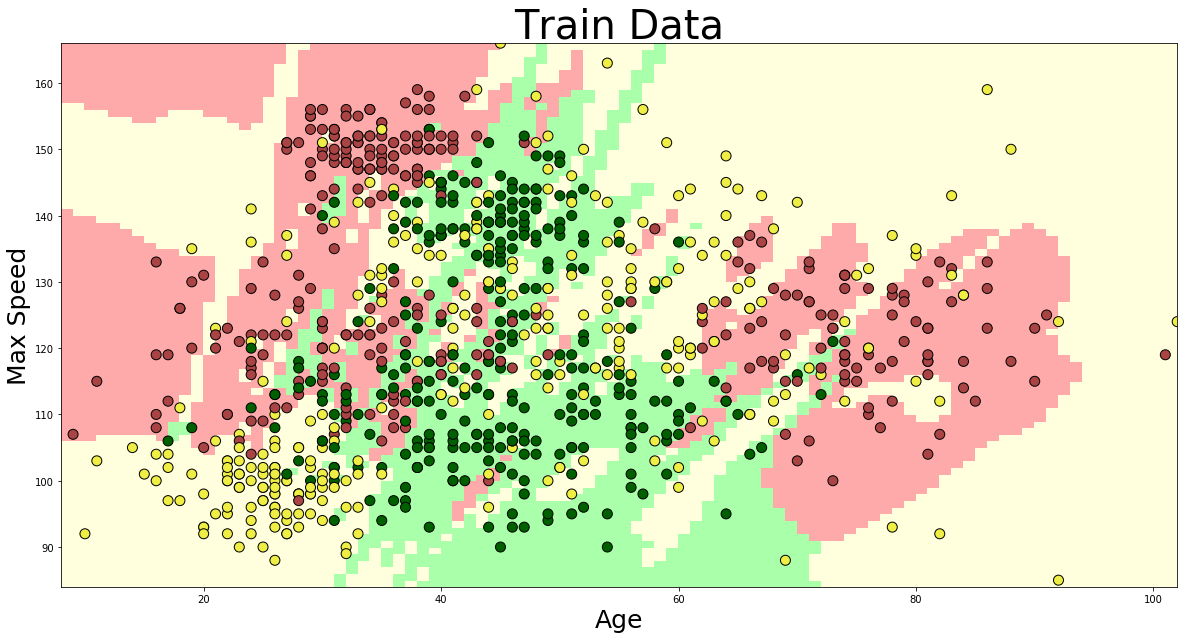

In [33]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

### Then for training data

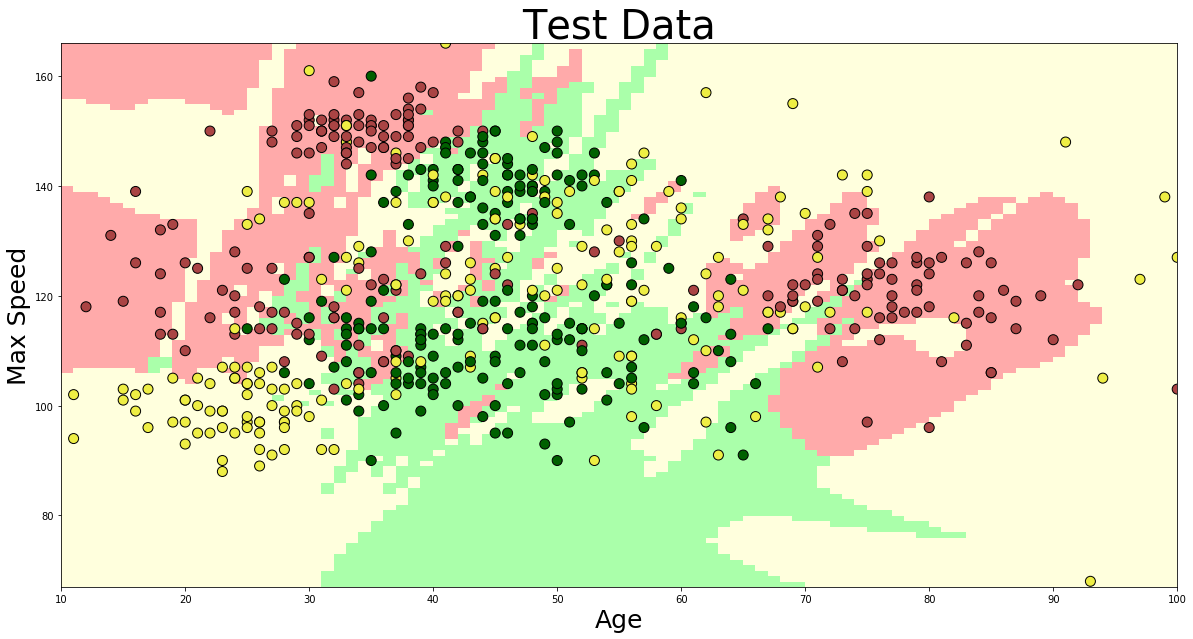

In [35]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data",
                fname='nn-overfit.png')

### A rule of thumb: Smoother decision boundaries imply less overfitting
This matches our observation: we detect overfitting and the decision boundaries also look rather wild, especially on the upper left side of the plot